<a href="https://colab.research.google.com/github/atharvar054/Employment-Sector-Growth-Prediction-and-Analysis/blob/main/Big_Data_Analytics.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Cell 1: Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.impute import KNNImputer
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, silhouette_score
import warnings
warnings.filterwarnings('ignore')

# Set style for plots
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

In [4]:
# Cell 2: Load and explore the data
# Load the data
df = pd.read_excel('employment_sectors.xlsx', sheet_name='Sheet1')

# Display basic information
print("Dataset Shape:", df.shape)
print("\nColumns:", df.columns.tolist())
print("\nFirst few rows:")
display(df.head())

print("\nData types:")
print(df.dtypes)

print("\nMissing values:")
print(df.isnull().sum())

Dataset Shape: (30, 18)

Columns: ['country', 'cnt', 'var', 'year', 'Agriculture', 'Mining', 'Manufacturing', 'Utilities', 'Construction', 'Trade services', 'Transport services', 'Business services', 'Financial services', 'Real estate', 'Government services', 'Other services', 'Total', 'War flag']

First few rows:


country  cnt var  year   Agriculture         Mining  Manufacturing  \
0   India  IND  VA  1990  1.549528e+06  152343.527512   9.641794e+05   
1   India  IND  VA  1991  1.810170e+06  166959.898389   1.061779e+06   
2   India  IND  VA  1992  2.030092e+06  192535.030360   1.209089e+06   
3   India  IND  VA  1993  2.354825e+06  223946.050508   1.419113e+06   
4   India  IND  VA  1994  2.711615e+06  252585.990204   1.740595e+06   

       Utilities   Construction  Trade services  Transport services  \
0  142070.904063  331015.428569   427481.477814       233853.210843   
1  173945.296618  372048.680550   486906.946432       272706.841602   
2  219671.772537  424495.460954   568013.462846       322279.009004   
3  258956.895073  468936.598447   666892.424767       377945.159475   
4  324890.663894  538881.943476   797373.287305       441937.596792   

   Business services  Financial services    Real estate  Government services  \
0      147482.854390       177946.938867  491583.440412        493468.193654   
1      178231.849022       242429.150083  563191.455870        573017.056490   
2      220435.373733       251790.808329  649950.738496        658868.355309   
3      269598.967670       330199.373872  749016.396158        732724.604015   
4      336184.895540       392722.685464  803954.072062        830938.499240   

   Other services         Total  War flag  
0   147589.479799  5.258543e+06         1  
1   169088.555809  6.070475e+06         1  
2   195136.539402  6.942357e+06         1  
3   224879.300606  8.077034e+06         0  
4   241373.393656  9.413053e+06         0


Data types:
country                 object
cnt                     object
var                     object
year                     int64
Agriculture            float64
Mining                 float64
Manufacturing          float64
Utilities              float64
Construction           float64
Trade services         float64
Transport services     float64
Business services      float64
Financial services     float64
Real estate            float64
Government services    float64
Other services         float64
Total                  float64
War flag                 int64
dtype: object

Missing values:
country                0
cnt                    0
var                    0
year                   0
Agriculture            0
Mining                 0
Manufacturing          0
Utilities              0
Construction           0
Trade services         0
Transport services     0
Business services      0
Financial services     0
Real estate            0
Government services    0
Other services         

In [5]:
# Cell 3: Add noise and NaN values to the dataset
def add_noise_and_nan(df, noise_level=0.03, nan_percentage=0.15):
    """
    Add random noise and NaN values to the dataset with more realistic patterns
    """
    df_noisy = df.copy()

    # Select only numeric columns for adding noise and NaN
    numeric_cols = df.select_dtypes(include=[np.number]).columns
    numeric_cols = [col for col in numeric_cols if col not in ['year', 'War flag', 'cnt']]

    # Add realistic random noise (proportional to value)
    for col in numeric_cols:
        # Add noise that scales with the value (percentage-based)
        noise = np.random.normal(0, noise_level, len(df)) * df[col].abs()
        df_noisy[col] = df[col] + noise

    # Add NaN values in more realistic patterns (not completely random)
    for col in numeric_cols:
        # Create blocks of missing data (more realistic than random points)
        block_size = max(2, int(len(df) * 0.1))  # 10% of data as block size
        num_blocks = int(len(df) * nan_percentage / block_size)

        for _ in range(num_blocks):
            start_idx = np.random.randint(0, len(df) - block_size)
            df_noisy.loc[start_idx:start_idx+block_size-1, col] = np.nan

    return df_noisy

# Create noisy dataset
df_noisy = add_noise_and_nan(df)
print("Original dataset missing values:", df.isnull().sum().sum())
print("Noisy dataset missing values:", df_noisy.isnull().sum().sum())

# Save the noisy dataset
df_noisy.to_csv('employment_noisy.csv', index=False)

Original dataset missing values: 0
Noisy dataset missing values: 39


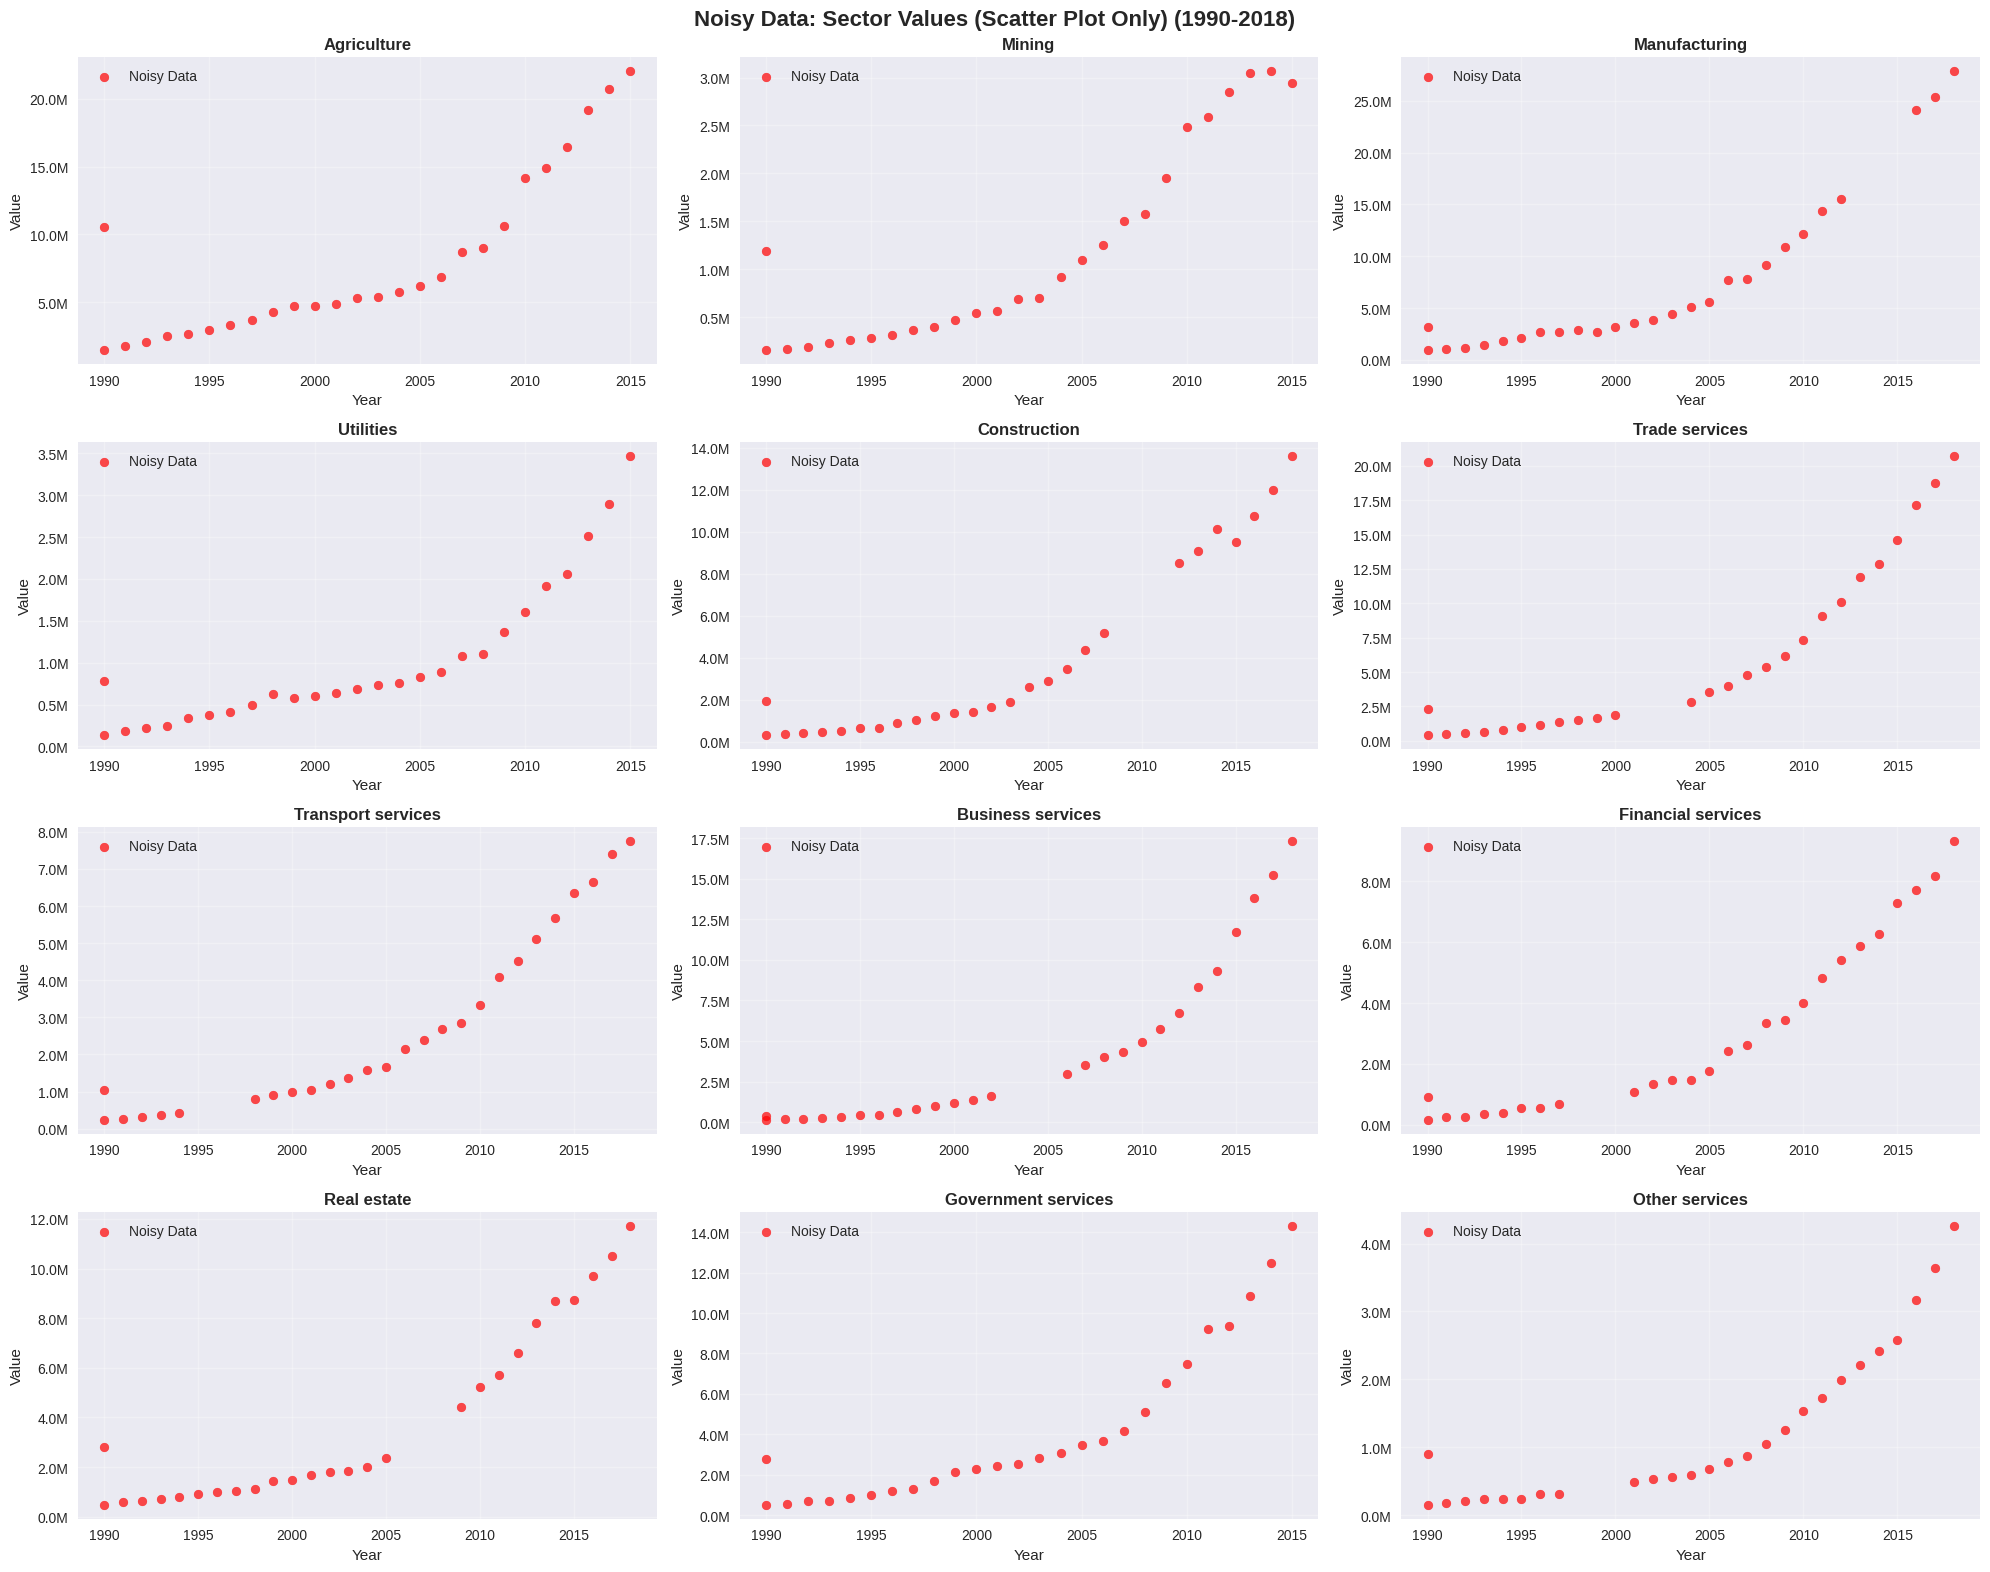

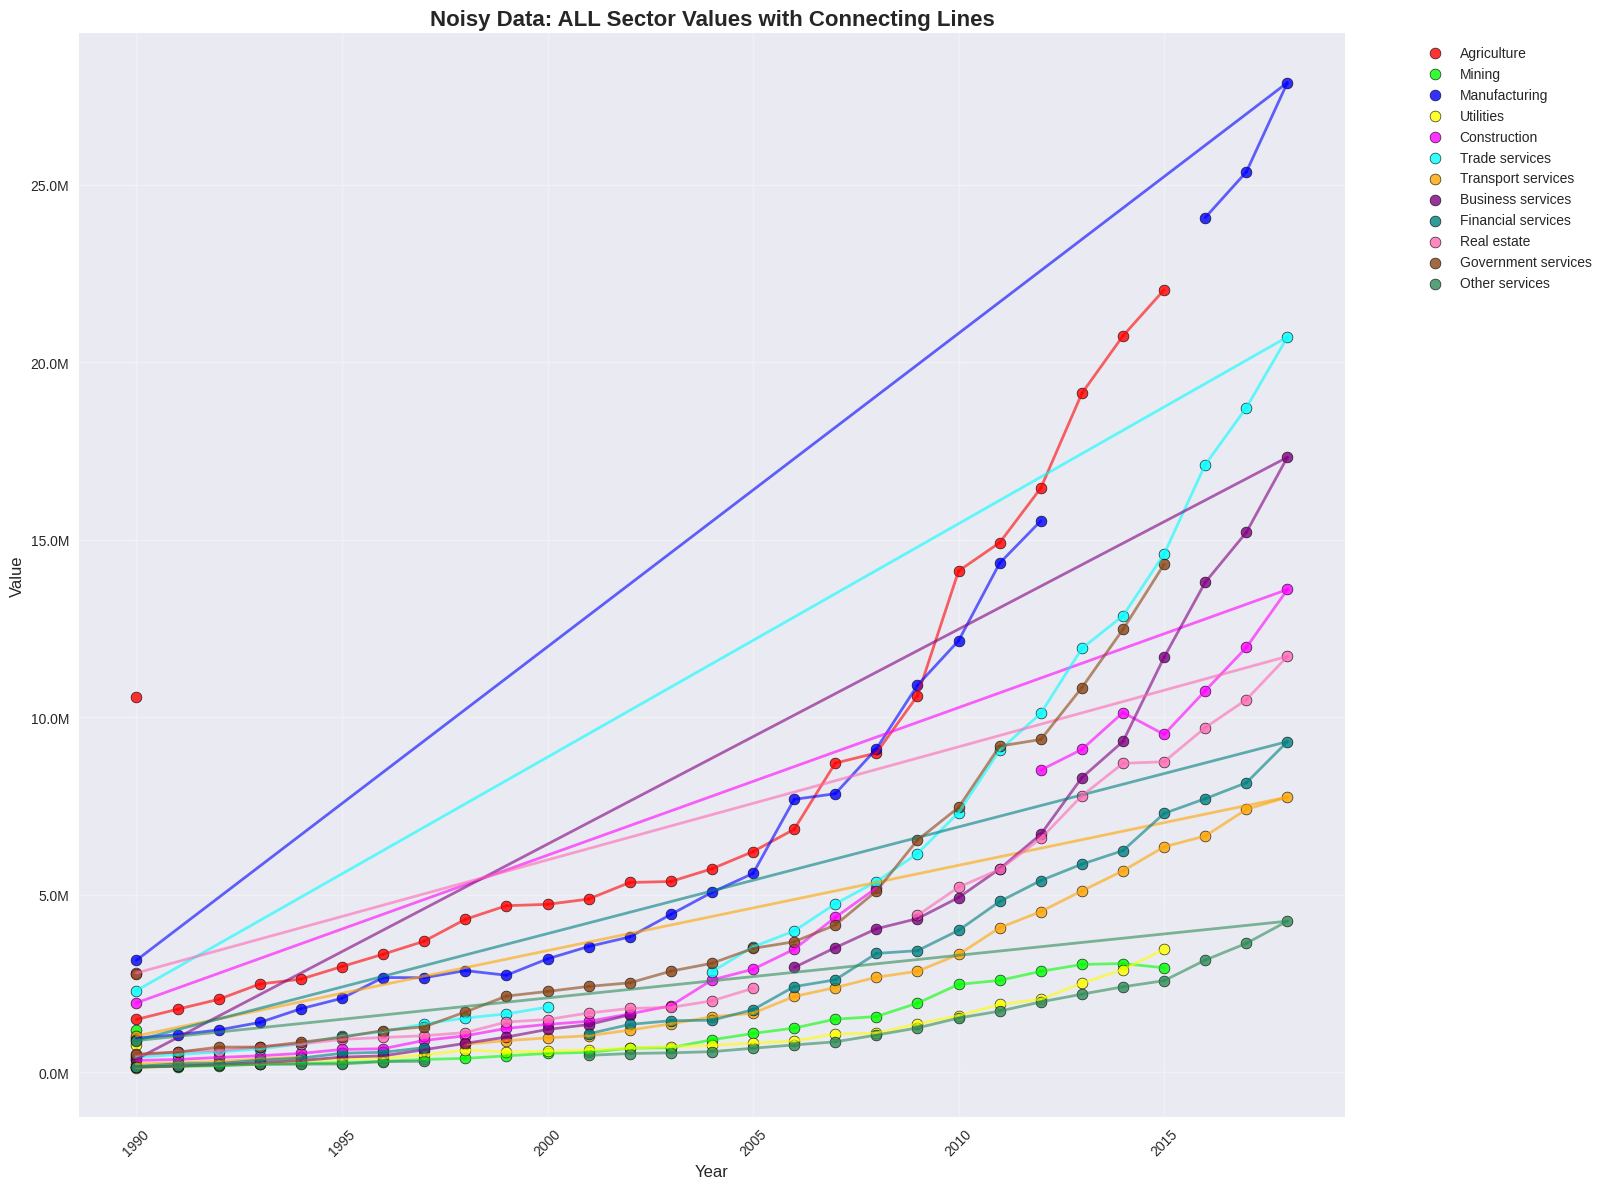

Plotting ALL 12 sectors:
1. Agriculture
2. Mining
3. Manufacturing
4. Utilities
5. Construction
6. Trade services
7. Transport services
8. Business services
9. Financial services
10. Real estate
11. Government services
12. Other services


In [6]:
# Cell 4: Visualization of noisy data - Scatter plots with connecting lines for ALL sectors
sector_columns = ['Agriculture', 'Mining', 'Manufacturing', 'Utilities',
                  'Construction', 'Trade services', 'Transport services',
                  'Business services', 'Financial services', 'Real estate',
                  'Government services', 'Other services']

# Create subplots with scatter plots only (no trend lines)
fig, axes = plt.subplots(4, 3, figsize=(20, 16))
axes = axes.flatten()

for i, sector in enumerate(sector_columns):
    ax = axes[i]

    # Plot non-null points only - scatter plot without any lines
    valid_mask = df_noisy[sector].notna()
    ax.scatter(df_noisy['year'][valid_mask], df_noisy[sector][valid_mask],
               color='red', alpha=0.7, s=40, label='Noisy Data')

    ax.set_title(f'{sector}', fontsize=12, fontweight='bold')
    ax.set_xlabel('Year')
    ax.set_ylabel('Value')
    ax.grid(True, alpha=0.3)
    ax.legend()
    # Format y-axis labels properly
    ax.ticklabel_format(style='scientific', axis='y', scilimits=(6,6))
    ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'{x/1e6:.1f}M'))

# Remove any empty subplots
for i in range(len(sector_columns), len(axes)):
    fig.delaxes(axes[i])

plt.suptitle('Noisy Data: Sector Values (Scatter Plot Only) (1990-2018)', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.subplots_adjust(top=0.95)
plt.show()

# Combined scatter plot for ALL sectors WITH CONNECTING LINES (no connections across missing data)
plt.figure(figsize=(18, 12))

# Define a color palette with enough distinct colors for all sectors
colors = ['#FF0000', '#00FF00', '#0000FF', '#FFFF00', '#FF00FF', '#00FFFF',
          '#FFA500', '#800080', '#008080', '#FF69B4', '#8B4513', '#2E8B57',
          '#1E90FF', '#FFD700', '#DA70D6', '#32CD32', '#FF6347', '#40E0D0',
          '#EE82EE', '#F0E68C']  # Extended color palette

# Use all sectors from sector_columns
all_sectors = sector_columns

for i, sector in enumerate(all_sectors):
    valid_mask = df_noisy[sector].notna()

    # Plot scatter points with distinct colors
    plt.scatter(df_noisy['year'][valid_mask], df_noisy[sector][valid_mask],
                color=colors[i % len(colors)], alpha=0.8, s=60,
                label=sector, edgecolors='black', linewidth=0.5)

    # Plot connecting lines only between consecutive non-missing points
    valid_data = df_noisy[['year', sector]].dropna()
    for j in range(len(valid_data) - 1):
        if valid_data.index[j+1] - valid_data.index[j] == 1:  # Check if consecutive years
            plt.plot(valid_data['year'].iloc[j:j+2], valid_data[sector].iloc[j:j+2],
                    '-', color=colors[i % len(colors)], linewidth=2, alpha=0.6)

plt.title('Noisy Data: ALL Sector Values with Connecting Lines', fontsize=16, fontweight='bold')
plt.xlabel('Year', fontsize=12)
plt.ylabel('Value', fontsize=12)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=10)
plt.grid(True, alpha=0.3)
plt.xticks(rotation=45)
plt.ticklabel_format(style='scientific', axis='y', scilimits=(6,6))
plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'{x/1e6:.1f}M'))

# Adjust layout to accommodate the larger legend
plt.tight_layout()
plt.subplots_adjust(right=0.75)  # Make space for the legend on the right
plt.show()

# Print summary of sectors being plotted
print(f"Plotting ALL {len(all_sectors)} sectors:")
for i, sector in enumerate(all_sectors):
    print(f"{i+1}. {sector}")

In [7]:
# Cell 5: Simple data cleaning without aggressive smoothing
def clean_data_simple(df_noisy):
    """
    Clean data using simple interpolation without aggressive smoothing
    """
    df_clean = df_noisy.copy()

    # Get numeric columns
    numeric_cols = df_noisy.select_dtypes(include=[np.number]).columns
    numeric_cols = [col for col in numeric_cols if col not in ['year', 'War flag', 'cnt']]

    # Use simple linear interpolation
    for col in numeric_cols:
        df_clean[col] = df_clean[col].interpolate(method='linear', limit_direction='both')

    # Fill any remaining missing values with forward/backward fill
    for col in numeric_cols:
        if df_clean[col].isnull().sum() > 0:
            df_clean[col] = df_clean[col].fillna(method='ffill').fillna(method='bfill')

    # Use very mild smoothing only to remove extreme spikes
    for col in numeric_cols:
        # Calculate rolling median to identify outliers
        rolling_median = df_clean[col].rolling(window=3, center=True, min_periods=1).median()
        rolling_std = df_clean[col].rolling(window=3, center=True, min_periods=1).std()

        # Replace only extreme outliers (more than 3 standard deviations)
        outliers = np.abs(df_clean[col] - rolling_median) > 3 * rolling_std
        df_clean.loc[outliers, col] = rolling_median[outliers]

    return df_clean

# Clean the data with simple method
df_clean = clean_data_simple(df_noisy)
print("Missing values after cleaning:", df_clean.isnull().sum().sum())
print("Data cleaning completed with minimal smoothing")

# Save cleaned data
df_clean.to_csv('employment_cleaned.csv', index=False)

Missing values after cleaning: 0
Data cleaning completed with minimal smoothing


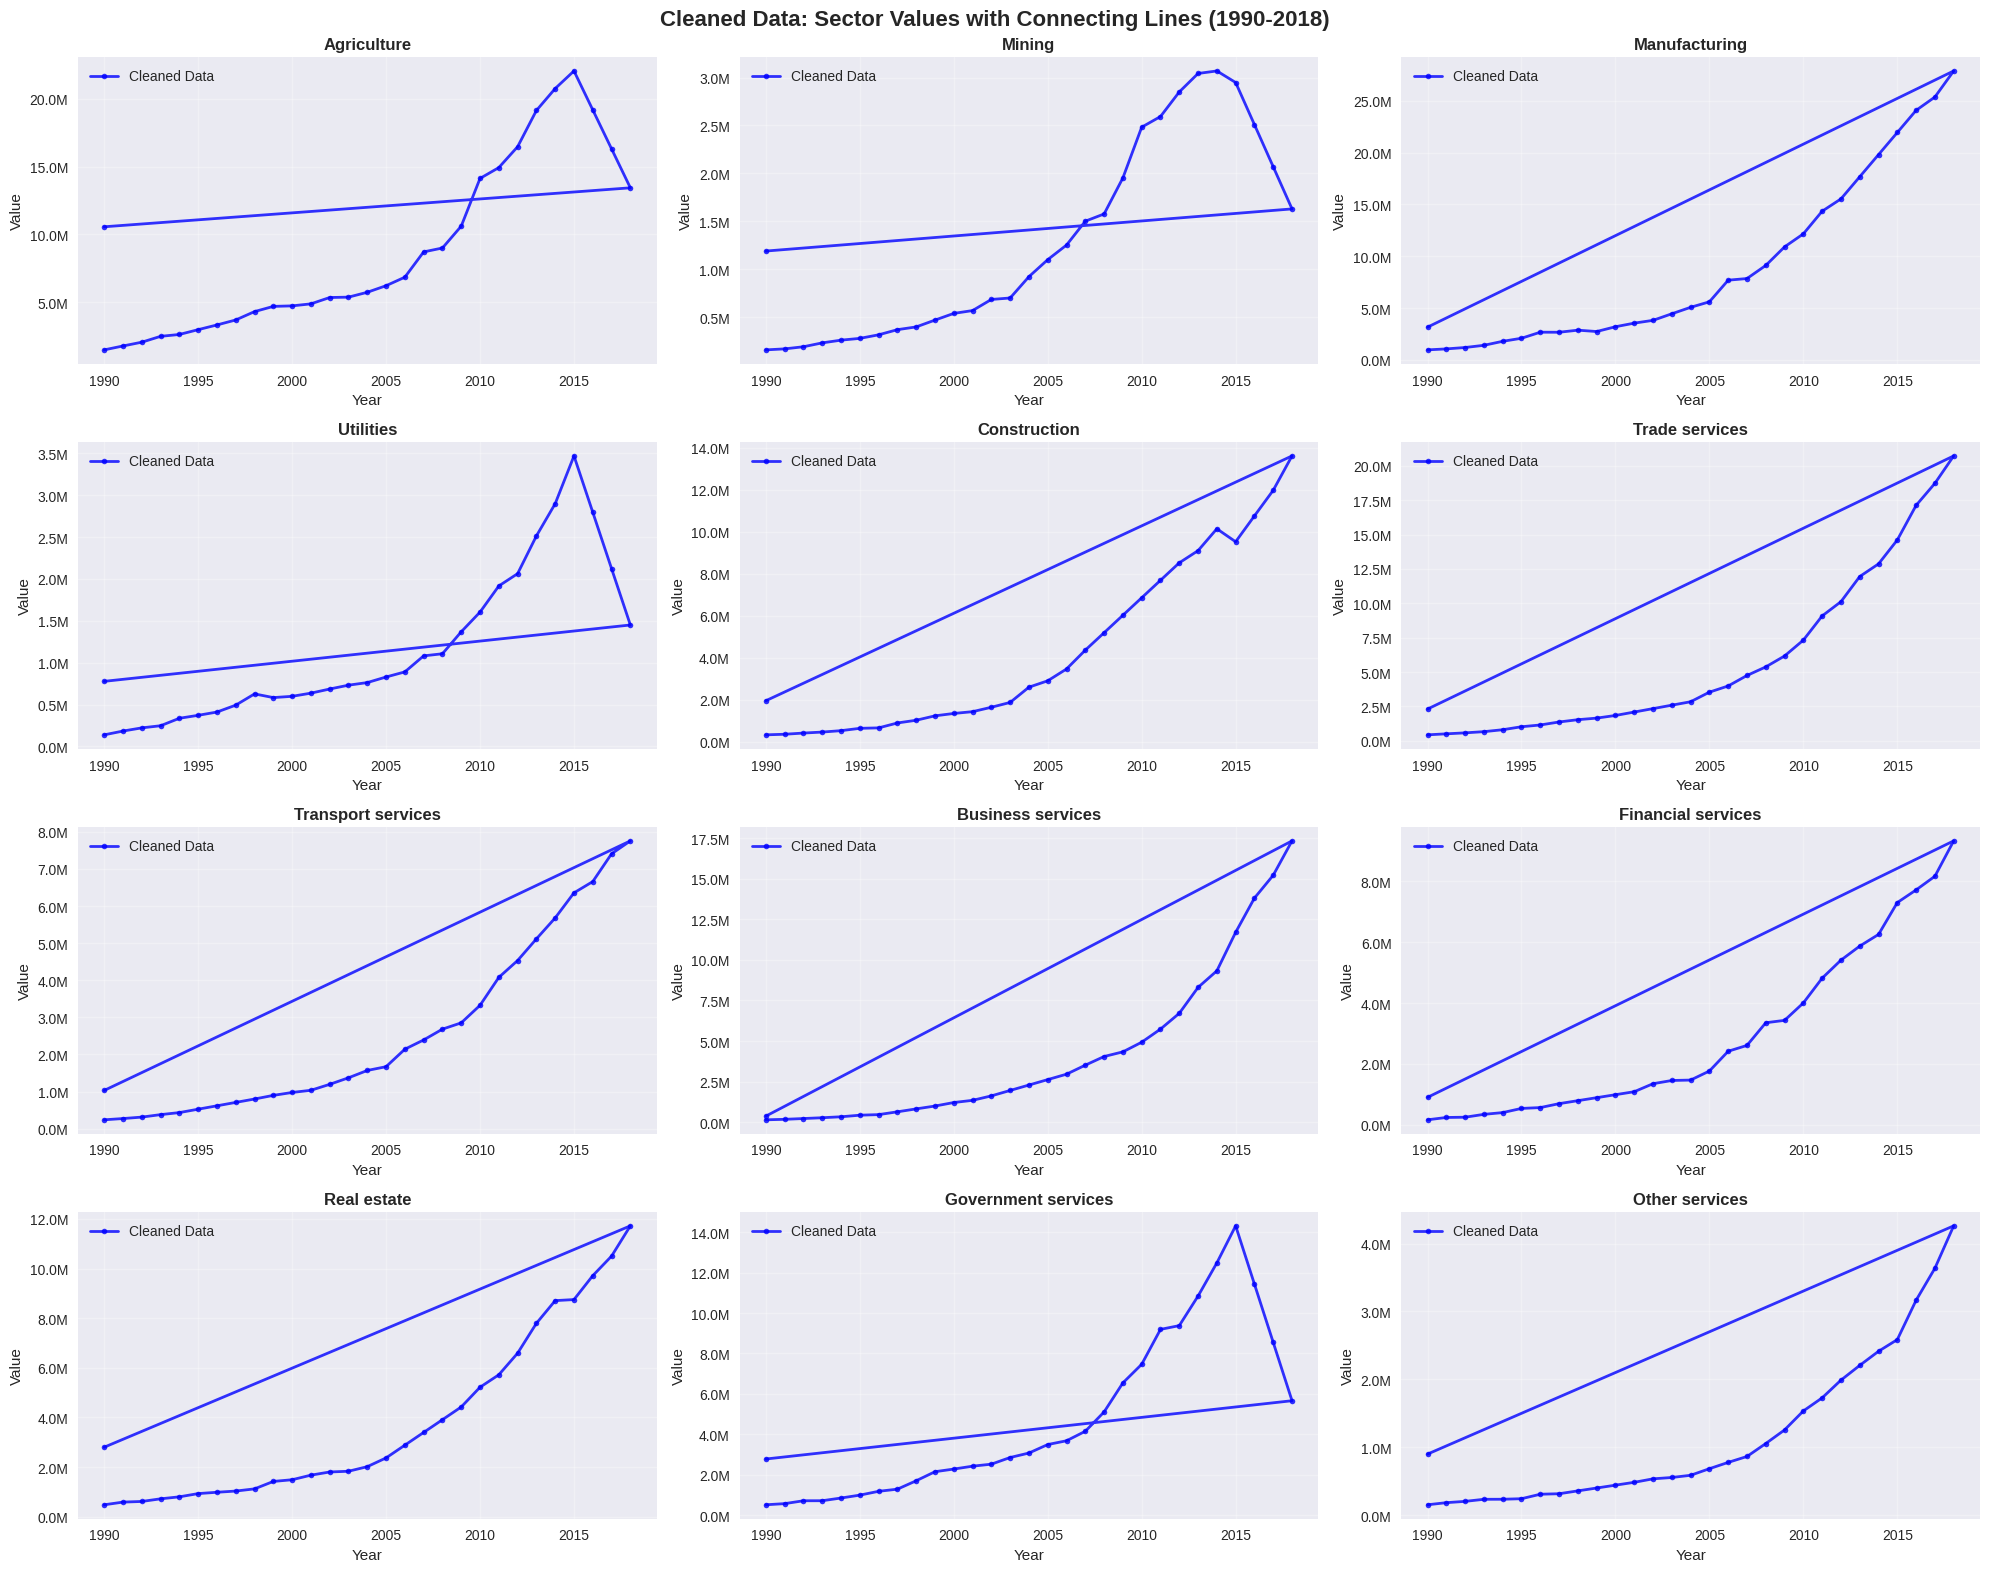

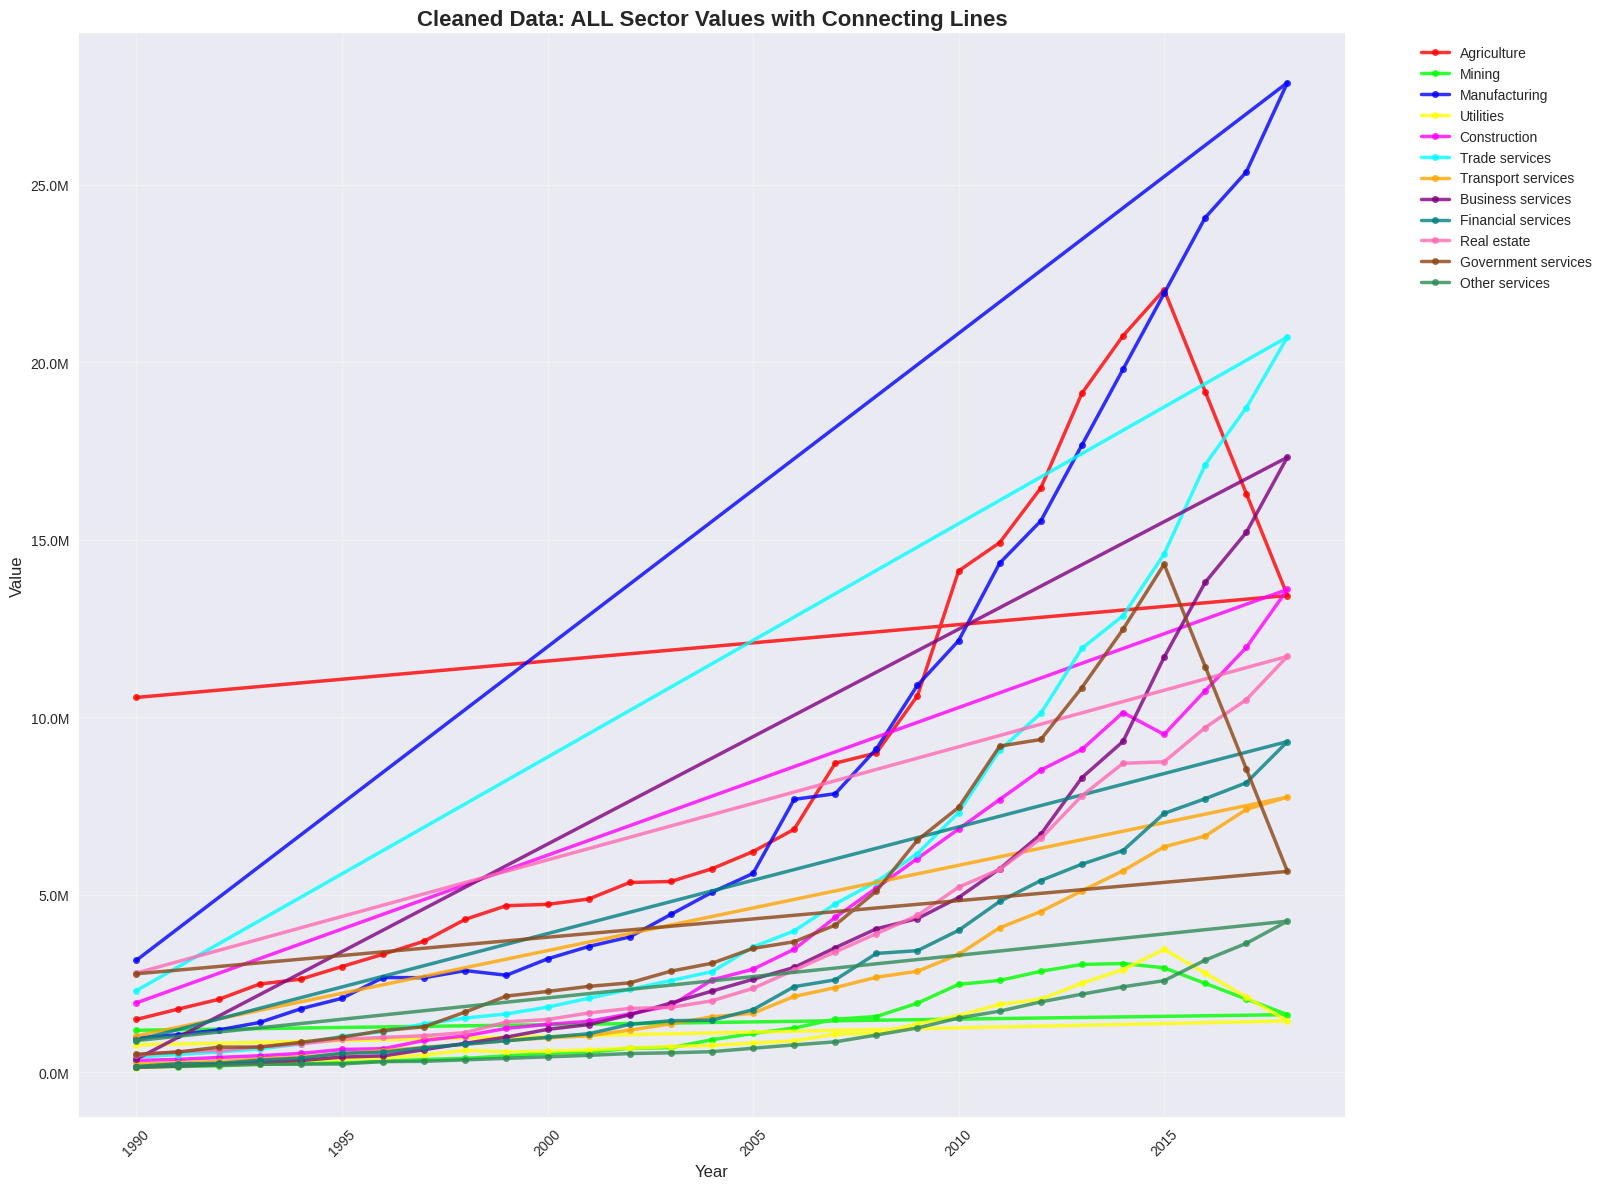

Plotting ALL 12 sectors:
1. Agriculture
2. Mining
3. Manufacturing
4. Utilities
5. Construction
6. Trade services
7. Transport services
8. Business services
9. Financial services
10. Real estate
11. Government services
12. Other services


In [8]:
# Cell 6: Visualization of cleaned data - With connecting lines for ALL sectors
fig, axes = plt.subplots(4, 3, figsize=(20, 16))
axes = axes.flatten()

for i, sector in enumerate(sector_columns):
    ax = axes[i]

    # Plot cleaned data with connecting lines and markers
    ax.plot(df_clean['year'], df_clean[sector], '-o', color='blue',
            markersize=4, alpha=0.8, label='Cleaned Data', linewidth=2)

    ax.set_title(f'{sector}', fontsize=12, fontweight='bold')
    ax.set_xlabel('Year')
    ax.set_ylabel('Value')
    ax.grid(True, alpha=0.3)
    ax.legend()
    ax.ticklabel_format(style='scientific', axis='y', scilimits=(6,6))
    ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'{x/1e6:.1f}M'))

# Remove any empty subplots
for i in range(len(sector_columns), len(axes)):
    fig.delaxes(axes[i])

plt.suptitle('Cleaned Data: Sector Values with Connecting Lines (1990-2018)', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.subplots_adjust(top=0.95)
plt.show()

# Combined plot for ALL sectors - with connecting lines and distinct colors
plt.figure(figsize=(18, 12))

# Define a color palette with enough distinct colors for all sectors
colors = ['#FF0000', '#00FF00', '#0000FF', '#FFFF00', '#FF00FF', '#00FFFF',
          '#FFA500', '#800080', '#008080', '#FF69B4', '#8B4513', '#2E8B57',
          '#1E90FF', '#FFD700', '#DA70D6', '#32CD32', '#FF6347', '#40E0D0',
          '#EE82EE', '#F0E68C']  # Extended color palette

# Use all sectors from sector_columns
all_sectors = sector_columns

for i, sector in enumerate(all_sectors):
    plt.plot(df_clean['year'], df_clean[sector], '-o', color=colors[i % len(colors)],
             markersize=5, alpha=0.8, label=sector, linewidth=2.5)

plt.title('Cleaned Data: ALL Sector Values with Connecting Lines', fontsize=16, fontweight='bold')
plt.xlabel('Year', fontsize=12)
plt.ylabel('Value', fontsize=12)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=10)
plt.grid(True, alpha=0.3)
plt.xticks(rotation=45)
plt.ticklabel_format(style='scientific', axis='y', scilimits=(6,6))
plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'{x/1e6:.1f}M'))

# Adjust layout to accommodate the larger legend
plt.tight_layout()
plt.subplots_adjust(right=0.75)  # Make space for the legend on the right
plt.show()

# Print summary of sectors being plotted
print(f"Plotting ALL {len(all_sectors)} sectors:")
for i, sector in enumerate(all_sectors):
    print(f"{i+1}. {sector}")

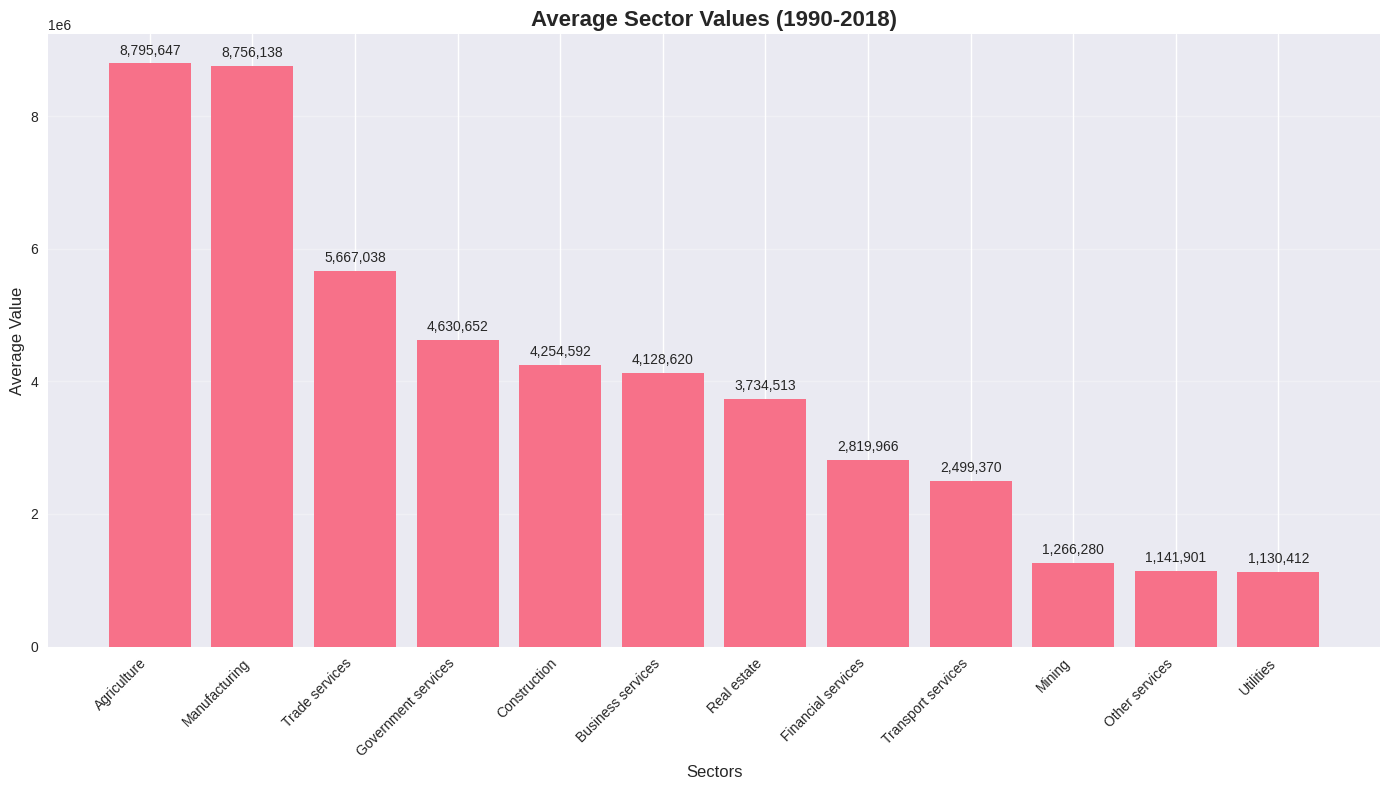

In [9]:
# Cell 7: Visualize cleaned data - Bar plot (average values by sector)
# Calculate average values for each sector
avg_values = df_clean[sector_columns].mean().sort_values(ascending=False)

plt.figure(figsize=(14, 8))
bars = plt.bar(range(len(avg_values)), avg_values.values)
plt.title('Average Sector Values (1990-2018)', fontsize=16, fontweight='bold')
plt.xlabel('Sectors', fontsize=12)
plt.ylabel('Average Value', fontsize=12)
plt.xticks(range(len(avg_values)), avg_values.index, rotation=45, ha='right')
plt.grid(True, alpha=0.3, axis='y')

# Add value labels on bars
for i, bar in enumerate(bars):
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height + max(avg_values)*0.01,
             f'{height:,.0f}', ha='center', va='bottom', rotation=0)

plt.tight_layout()
plt.show()

In [10]:
# Cell 9.1: Sector contribution analysis using classification model RandomForest
# Prepare data for classification
sector_data = df_clean[sector_columns].copy()
total_gdp = sector_data.sum(axis=1)

# Calculate percentage contribution of each sector
sector_contribution = sector_data.div(total_gdp, axis=0) * 100

# Create target variable: which sector contributes most to GDP each year
dominant_sectors = sector_contribution.idxmax(axis=1)

# Prepare features and target
X = df_clean[['year'] + sector_columns].copy()
y = dominant_sectors

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train Random Forest classifier
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)
rf_classifier.fit(X_train, y_train)

# Predictions
y_pred = rf_classifier.predict(X_test)

# Evaluation
print("Classification Report:")
print(classification_report(y_test, y_pred))


Classification Report:
               precision    recall  f1-score   support

  Agriculture       1.00      0.80      0.89         5
Manufacturing       0.50      1.00      0.67         1

     accuracy                           0.83         6
    macro avg       0.75      0.90      0.78         6
 weighted avg       0.92      0.83      0.85         6



Growth Prediction Analysis:
Agriculture: 9/29 years (31.0%) with above-average growth
Mining: 11/29 years (37.9%) with above-average growth
Manufacturing: 16/29 years (55.2%) with above-average growth
Utilities: 12/29 years (41.4%) with above-average growth
Construction: 14/29 years (48.3%) with above-average growth
Trade services: 16/29 years (55.2%) with above-average growth
Transport services: 14/29 years (48.3%) with above-average growth
Business services: 24/29 years (82.8%) with above-average growth
Financial services: 17/29 years (58.6%) with above-average growth
Real estate: 13/29 years (44.8%) with above-average growth
Government services: 13/29 years (44.8%) with above-average growth
Other services: 12/29 years (41.4%) with above-average growth


<Figure size 1600x1000 with 0 Axes>

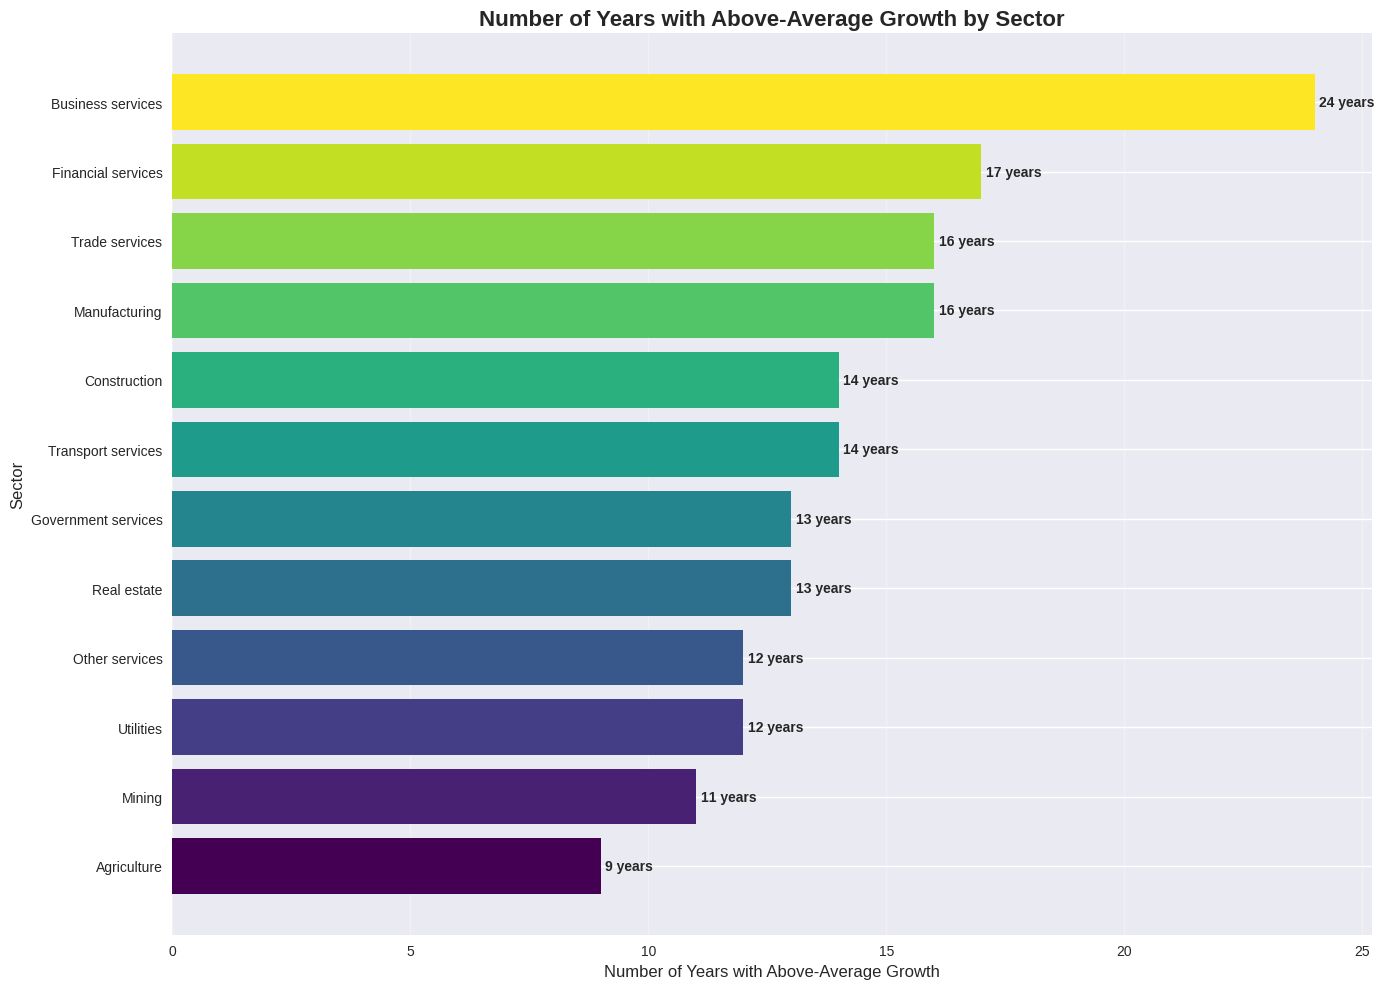

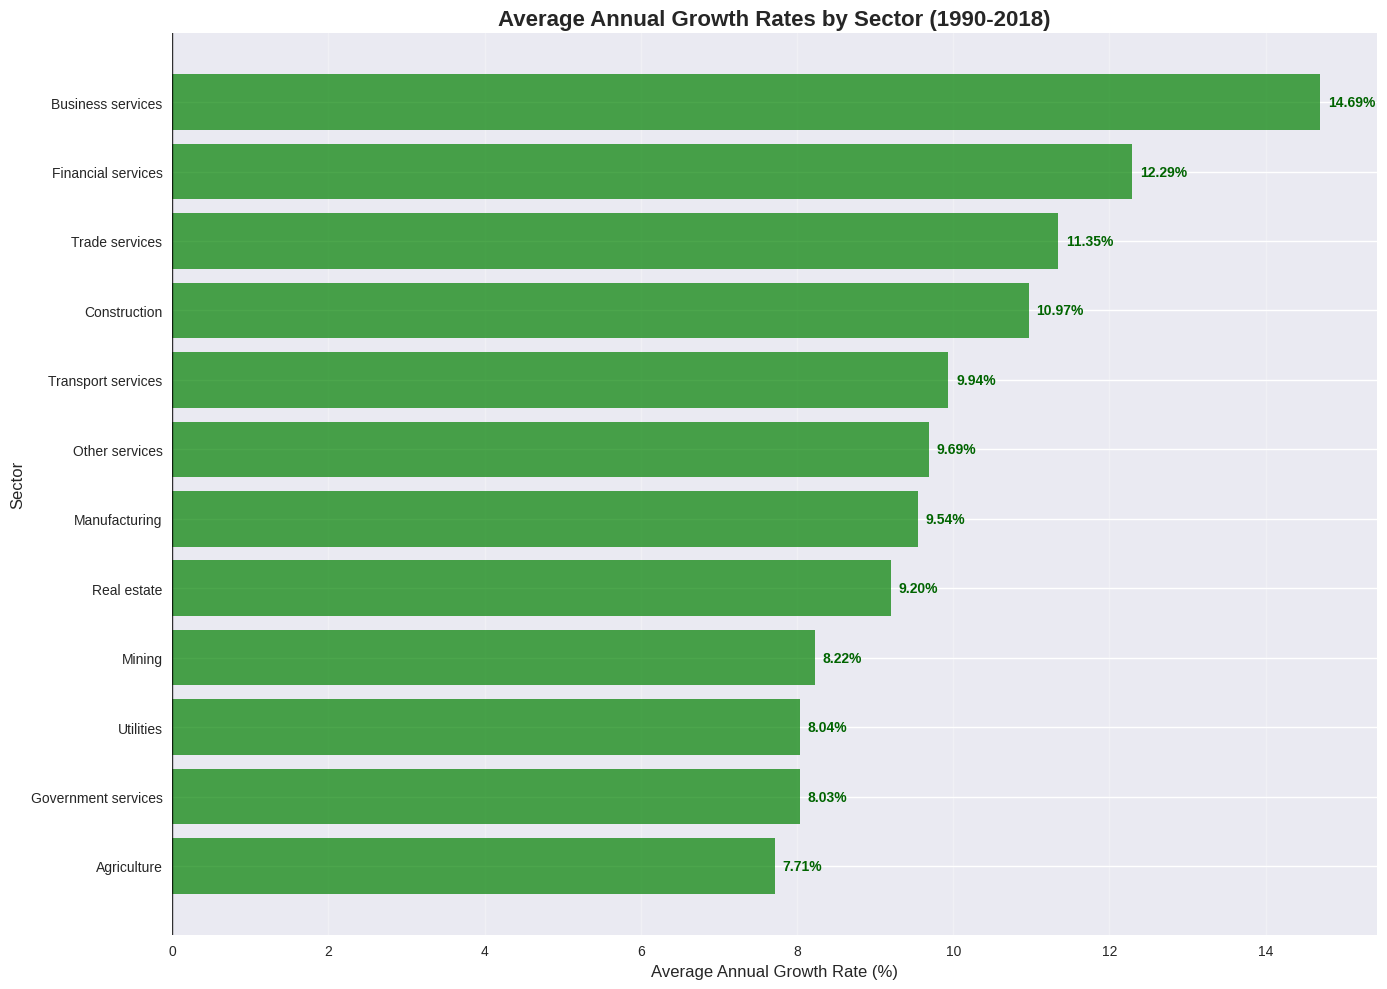

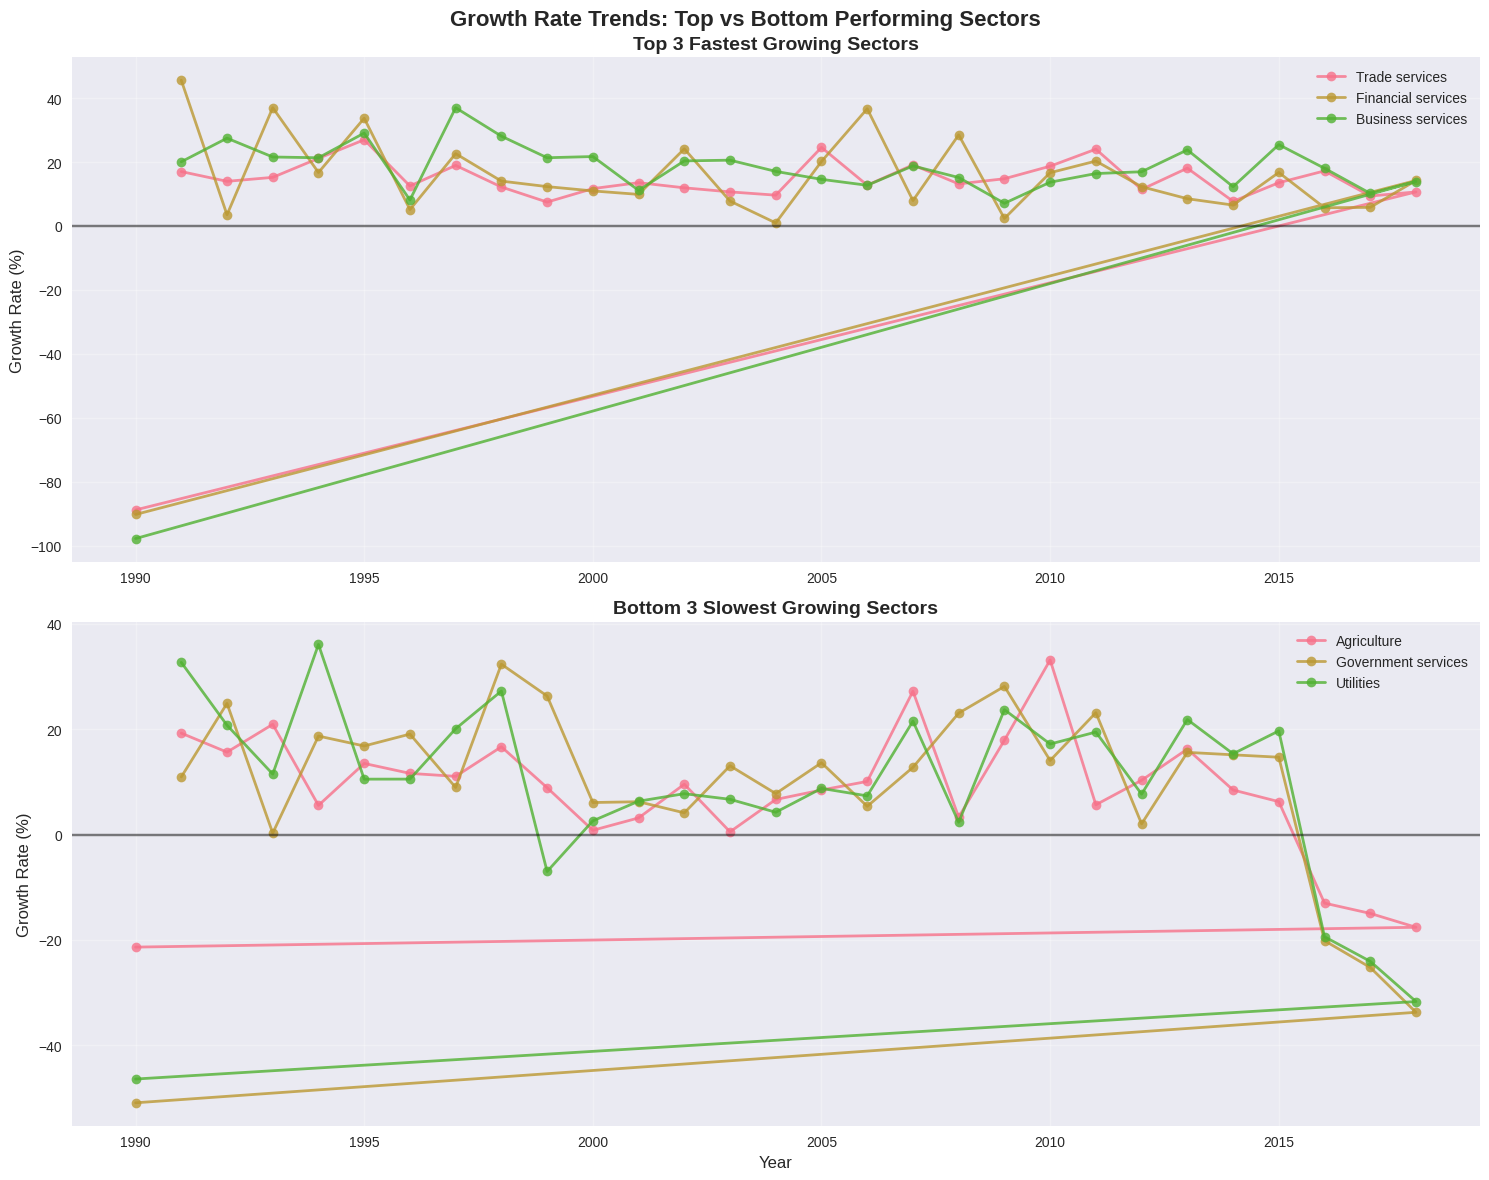

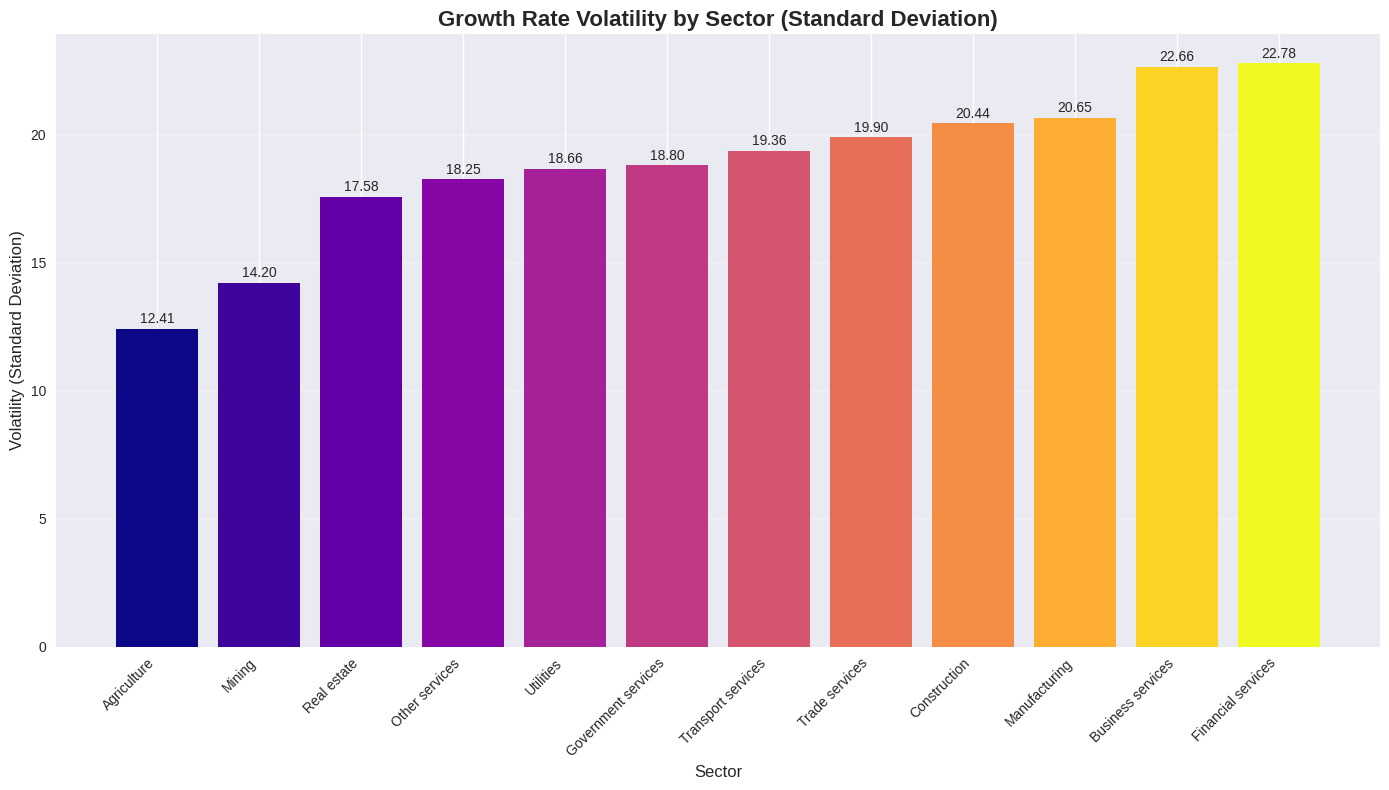

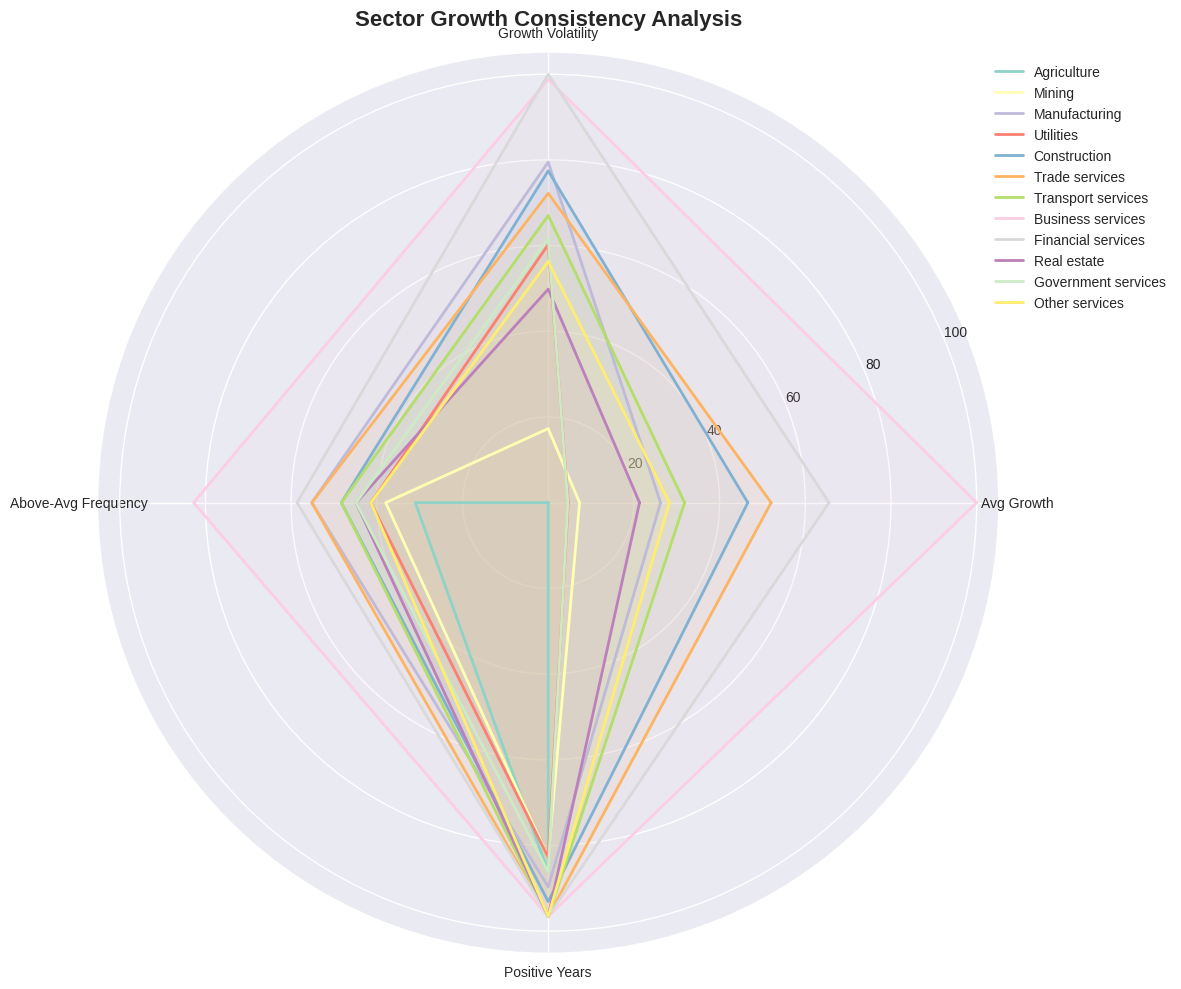


GROWTH ANALYSIS SUMMARY

Top 3 fastest growing sectors:
  1. Business services: 14.69% average growth
  2. Financial services: 12.29% average growth
  3. Trade services: 11.35% average growth

Most consistent sectors (most above-average years):
  1. Business services: 24 above-average years
  2. Financial services: 17 above-average years
  3. Trade services: 16 above-average years

Most volatile sectors:
  1. Financial services: 22.78 standard deviation
  2. Business services: 22.66 standard deviation
  3. Manufacturing: 20.65 standard deviation


In [11]:
# Cell 9.2: Predictive analysis - Which sectors will grow with enhanced visualization
# Prepare data for growth prediction
growth_data = df_clean.copy()
for sector in sector_columns:
    # Calculate year-over-year growth rate
    growth_data[f'{sector}_growth'] = growth_data[sector].pct_change() * 100

# Remove first row with NaN growth rates
growth_data = growth_data.dropna()

# Predict which sectors will have above-average growth next year
avg_growth = growth_data[[f'{sector}_growth' for sector in sector_columns]].mean(axis=1)
target_growth = (growth_data[[f'{sector}_growth' for sector in sector_columns]] > avg_growth.values[:, None]).astype(int)

print("Growth Prediction Analysis:")
for i, sector in enumerate(sector_columns):
    above_avg_count = target_growth[f'{sector}_growth'].sum()
    total_years = len(target_growth)
    percentage = (above_avg_count / total_years) * 100
    print(f"{sector}: {above_avg_count}/{total_years} years ({percentage:.1f}%) with above-average growth")

# Visualization 1: Heatmap of above-average growth years
plt.figure(figsize=(16, 10))
sector_growth_matrix = target_growth[[f'{sector}_growth' for sector in sector_columns]]
sector_growth_matrix.columns = sector_columns  # Remove '_growth' suffix for readability

# Visualization 2: Bar plot of above-average growth frequency
above_avg_counts = []
for sector in sector_columns:
    above_avg_count = target_growth[f'{sector}_growth'].sum()
    above_avg_counts.append(above_avg_count)

above_avg_series = pd.Series(above_avg_counts, index=sector_columns)
above_avg_series = above_avg_series.sort_values(ascending=True)

plt.figure(figsize=(14, 10))
bars = plt.barh(range(len(above_avg_series)), above_avg_series.values,
                color=plt.cm.viridis(np.linspace(0, 1, len(above_avg_series))))

plt.title('Number of Years with Above-Average Growth by Sector', fontsize=16, fontweight='bold')
plt.xlabel('Number of Years with Above-Average Growth', fontsize=12)
plt.ylabel('Sector', fontsize=12)
plt.yticks(range(len(above_avg_series)), above_avg_series.index)

# Add value labels
for i, bar in enumerate(bars):
    width = bar.get_width()
    plt.text(width + 0.1, bar.get_y() + bar.get_height()/2,
             f'{int(width)} years', ha='left', va='center', fontweight='bold')

plt.grid(True, alpha=0.3, axis='x')
plt.tight_layout()
plt.show()

# Visualization 3: Average growth rates by sector
avg_growth_rates = {}
for sector in sector_columns:
    avg_growth_rate = growth_data[f'{sector}_growth'].mean()
    avg_growth_rates[sector] = avg_growth_rate

avg_growth_series = pd.Series(avg_growth_rates).sort_values(ascending=True)

plt.figure(figsize=(14, 10))
colors = ['red' if x < 0 else 'green' for x in avg_growth_series.values]
bars = plt.barh(range(len(avg_growth_series)), avg_growth_series.values, color=colors, alpha=0.7)

plt.title('Average Annual Growth Rates by Sector (1990-2018)', fontsize=16, fontweight='bold')
plt.xlabel('Average Annual Growth Rate (%)', fontsize=12)
plt.ylabel('Sector', fontsize=12)
plt.yticks(range(len(avg_growth_series)), avg_growth_series.index)
plt.axvline(x=0, color='black', linestyle='-', alpha=0.8)

# Add value labels
for i, bar in enumerate(bars):
    width = bar.get_width()
    plt.text(width + (0.1 if width >= 0 else -0.1), bar.get_y() + bar.get_height()/2,
             f'{width:.2f}%', ha='left' if width >= 0 else 'right', va='center',
             fontweight='bold', color='darkgreen' if width >= 0 else 'darkred')

plt.grid(True, alpha=0.3, axis='x')
plt.tight_layout()
plt.show()

# Visualization 4: Growth trend comparison for top and bottom sectors
# Identify top and bottom 3 sectors by average growth
top_sectors = avg_growth_series.tail(3).index.tolist()
bottom_sectors = avg_growth_series.head(3).index.tolist()

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 12))

# Plot top growing sectors
for sector in top_sectors:
    ax1.plot(growth_data['year'], growth_data[f'{sector}_growth'],
             marker='o', linewidth=2, label=sector, alpha=0.8)
ax1.set_title('Top 3 Fastest Growing Sectors', fontsize=14, fontweight='bold')
ax1.set_ylabel('Growth Rate (%)', fontsize=12)
ax1.legend()
ax1.grid(True, alpha=0.3)
ax1.axhline(y=0, color='black', linestyle='-', alpha=0.5)

# Plot bottom growing sectors
for sector in bottom_sectors:
    ax2.plot(growth_data['year'], growth_data[f'{sector}_growth'],
             marker='o', linewidth=2, label=sector, alpha=0.8)
ax2.set_title('Bottom 3 Slowest Growing Sectors', fontsize=14, fontweight='bold')
ax2.set_xlabel('Year', fontsize=12)
ax2.set_ylabel('Growth Rate (%)', fontsize=12)
ax2.legend()
ax2.grid(True, alpha=0.3)
ax2.axhline(y=0, color='black', linestyle='-', alpha=0.5)

plt.suptitle('Growth Rate Trends: Top vs Bottom Performing Sectors', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

# Visualization 5: Growth volatility analysis
growth_volatility = {}
for sector in sector_columns:
    volatility = growth_data[f'{sector}_growth'].std()
    growth_volatility[sector] = volatility

volatility_series = pd.Series(growth_volatility).sort_values(ascending=True)

plt.figure(figsize=(14, 8))
bars = plt.bar(range(len(volatility_series)), volatility_series.values,
               color=plt.cm.plasma(np.linspace(0, 1, len(volatility_series))))

plt.title('Growth Rate Volatility by Sector (Standard Deviation)', fontsize=16, fontweight='bold')
plt.xlabel('Sector', fontsize=12)
plt.ylabel('Volatility (Standard Deviation)', fontsize=12)
plt.xticks(range(len(volatility_series)), volatility_series.index, rotation=45, ha='right')

# Add value labels
for i, bar in enumerate(bars):
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height + 0.1,
             f'{height:.2f}', ha='center', va='bottom', rotation=0)

plt.grid(True, alpha=0.3, axis='y')
plt.tight_layout()
plt.show()

# Visualization 6: Growth consistency radar chart
def plot_growth_consistency_radar(sectors_data):
    """Create radar chart for growth consistency analysis"""
    categories = ['Avg Growth', 'Growth Volatility', 'Above-Avg Frequency', 'Positive Years']

    # Normalize data for radar chart
    normalized_data = {}
    for sector, data in sectors_data.items():
        normalized = [
            (data['avg_growth'] - min([d['avg_growth'] for d in sectors_data.values()])) /
            (max([d['avg_growth'] for d in sectors_data.values()]) - min([d['avg_growth'] for d in sectors_data.values()])) * 100,
            (data['volatility'] - min([d['volatility'] for d in sectors_data.values()])) /
            (max([d['volatility'] for d in sectors_data.values()]) - min([d['volatility'] for d in sectors_data.values()])) * 100,
            data['above_avg_freq'] * 100,  # Already percentage
            data['positive_years'] * 100   # Already percentage
        ]
        normalized_data[sector] = normalized

    fig = plt.figure(figsize=(12, 10))
    ax = fig.add_subplot(111, polar=True)

    angles = np.linspace(0, 2*np.pi, len(categories), endpoint=False).tolist()
    angles += angles[:1]  # Close the circle

    colors = plt.cm.Set3(np.linspace(0, 1, len(sectors_data)))

    for i, (sector, values) in enumerate(normalized_data.items()):
        values += values[:1]  # Close the circle
        ax.plot(angles, values, linewidth=2, label=sector, color=colors[i])
        ax.fill(angles, values, alpha=0.1, color=colors[i])

    ax.set_thetagrids(np.degrees(angles[:-1]), categories)
    ax.set_title('Sector Growth Consistency Analysis', fontsize=16, fontweight='bold', pad=20)
    ax.legend(bbox_to_anchor=(1.2, 1))
    plt.tight_layout()
    plt.show()

# Prepare data for radar chart
sectors_analysis = {}
for sector in sector_columns:
    sectors_analysis[sector] = {
        'avg_growth': growth_data[f'{sector}_growth'].mean(),
        'volatility': growth_data[f'{sector}_growth'].std(),
        'above_avg_freq': target_growth[f'{sector}_growth'].mean(),
        'positive_years': (growth_data[f'{sector}_growth'] > 0).mean()
    }

plot_growth_consistency_radar(sectors_analysis)

# Summary statistics
print("\n" + "="*60)
print("GROWTH ANALYSIS SUMMARY")
print("="*60)

print(f"\nTop 3 fastest growing sectors:")
for i, sector in enumerate(avg_growth_series.tail(3).index[::-1]):
    growth = avg_growth_series[sector]
    print(f"  {i+1}. {sector}: {growth:.2f}% average growth")

print(f"\nMost consistent sectors (most above-average years):")
consistent_sectors = above_avg_series.tail(3).index[::-1]
for i, sector in enumerate(consistent_sectors):
    count = above_avg_series[sector]
    print(f"  {i+1}. {sector}: {count} above-average years")

print(f"\nMost volatile sectors:")
volatile_sectors = volatility_series.tail(3).index[::-1]
for i, sector in enumerate(volatile_sectors):
    vol = volatility_series[sector]
    print(f"  {i+1}. {sector}: {vol:.2f} standard deviation")

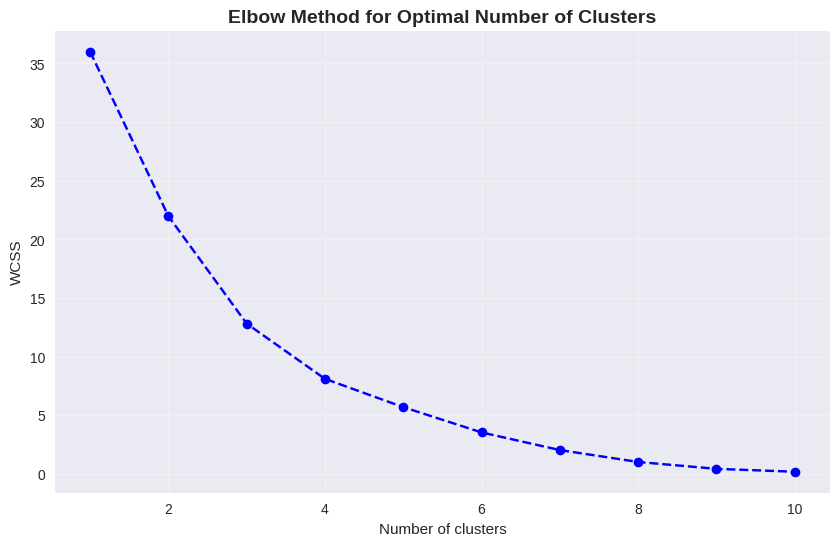

<Figure size 1400x1000 with 0 Axes>

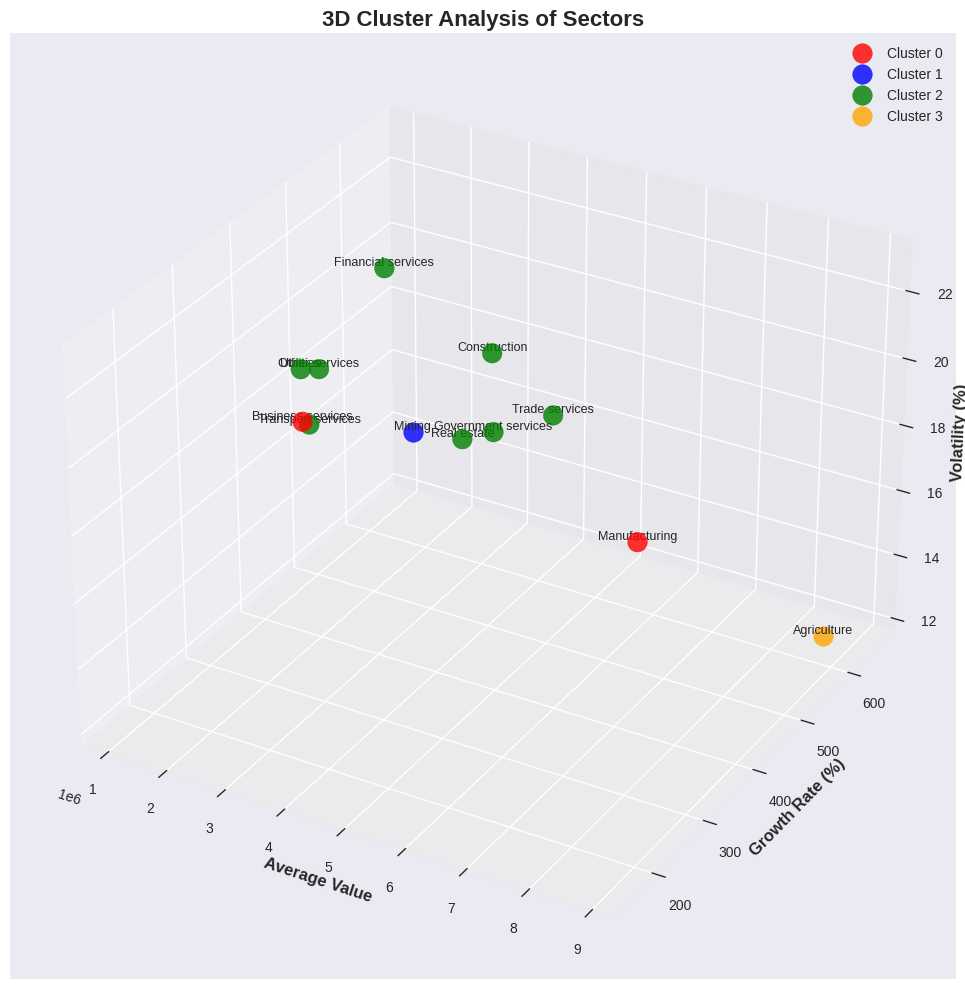

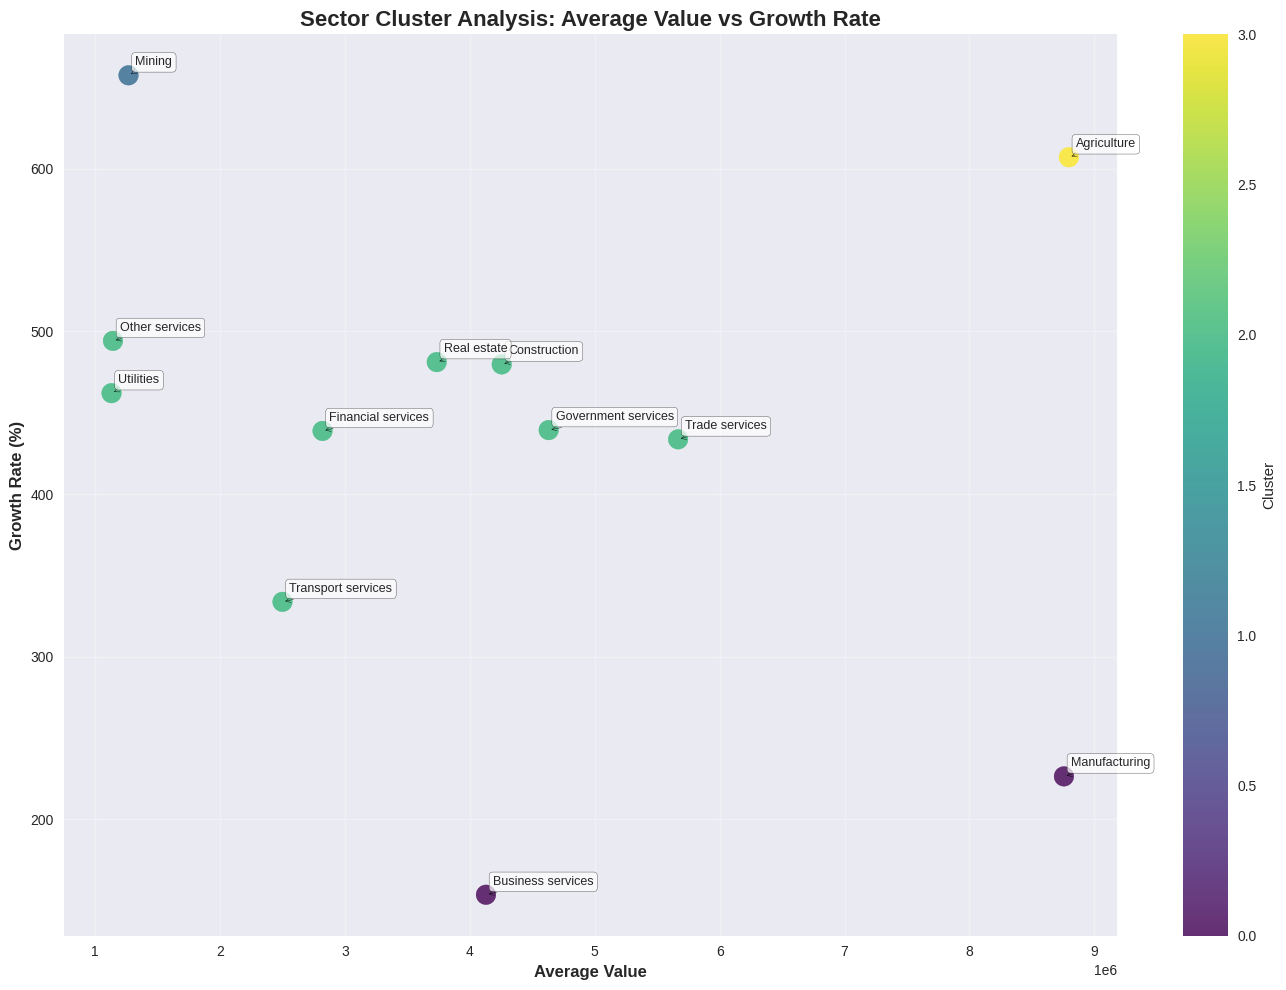

Cluster Analysis Results:

Cluster 0 (2 sectors):
Sectors: Manufacturing, Business services
Average Value: 6,442,379
Average Growth Rate: 190.06%
Average Volatility: 21.65%

Cluster 1 (1 sectors):
Sectors: Mining
Average Value: 1,266,280
Average Growth Rate: 657.50%
Average Volatility: 14.20%

Cluster 2 (8 sectors):
Sectors: Utilities, Construction, Trade services, Transport services, Financial services, Real estate, Government services, Other services
Average Value: 3,234,805
Average Growth Rate: 445.36%
Average Volatility: 19.47%

Cluster 3 (1 sectors):
Sectors: Agriculture
Average Value: 8,795,647
Average Growth Rate: 607.13%
Average Volatility: 12.41%

Cluster Summary Statistics:
          avg_value             growth_rate        volatility      
               mean         std        mean    std       mean   std
cluster                                                            
0        6442378.85  3272148.98      190.06  51.46      21.65  1.42
1        1266280.32         NaN    

In [12]:
# Cell 10: Corrected Cluster analysis of sectors
# Prepare proper data for clustering - we need to cluster sectors, not years
# We'll use the average characteristics of each sector across all years

# Calculate average values for each sector across all years
sector_avg = df_clean[sector_columns].mean().reset_index()
sector_avg.columns = ['sector', 'average_value']

# Calculate growth rates for clustering
sector_stats = pd.DataFrame()
for sector in sector_columns:
    sector_data = df_clean[sector]
    sector_stats.loc[sector, 'avg_value'] = sector_data.mean()
    sector_stats.loc[sector, 'growth_rate'] = (sector_data.iloc[-1] - sector_data.iloc[0]) / sector_data.iloc[0] * 100
    sector_stats.loc[sector, 'volatility'] = sector_data.pct_change().std() * 100

# Standardize the data for clustering
scaler = StandardScaler()
scaled_stats = scaler.fit_transform(sector_stats)

# Determine optimal number of clusters using elbow method
wcss = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, random_state=42, n_init=10)
    kmeans.fit(scaled_stats)
    wcss.append(kmeans.inertia_)

plt.figure(figsize=(10, 6))
plt.plot(range(1, 11), wcss, marker='o', linestyle='--', color='blue')
plt.title('Elbow Method for Optimal Number of Clusters', fontsize=14, fontweight='bold')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.grid(True, alpha=0.3)
plt.show()

# Apply K-means clustering with optimal clusters
optimal_clusters = 4  # Based on elbow method
kmeans = KMeans(n_clusters=optimal_clusters, random_state=42, n_init=10)
sector_clusters = kmeans.fit_predict(scaled_stats)

# Add cluster labels to sector stats
sector_stats['cluster'] = sector_clusters

# Visualize clusters using the actual metrics
plt.figure(figsize=(14, 10))

# Create a 3D plot for better visualization of the 3 metrics
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(12, 10))
ax = fig.add_subplot(111, projection='3d')

# Color map for clusters
colors = ['red', 'blue', 'green', 'orange', 'purple', 'brown']
for cluster_id in range(optimal_clusters):
    cluster_data = sector_stats[sector_stats['cluster'] == cluster_id]
    ax.scatter(cluster_data['avg_value'], cluster_data['growth_rate'],
               cluster_data['volatility'],
               c=colors[cluster_id], s=200, label=f'Cluster {cluster_id}', alpha=0.8)

ax.set_xlabel('Average Value', fontsize=12, fontweight='bold')
ax.set_ylabel('Growth Rate (%)', fontsize=12, fontweight='bold')
ax.set_zlabel('Volatility (%)', fontsize=12, fontweight='bold')
ax.set_title('3D Cluster Analysis of Sectors', fontsize=16, fontweight='bold')
ax.legend()

# Add sector labels
for sector, row in sector_stats.iterrows():
    ax.text(row['avg_value'], row['growth_rate'], row['volatility'],
            sector, fontsize=9, ha='center', va='bottom')

plt.tight_layout()
plt.show()

# Also create a 2D scatter plot for better readability
plt.figure(figsize=(14, 10))
scatter = plt.scatter(sector_stats['avg_value'], sector_stats['growth_rate'],
                     c=sector_stats['cluster'], cmap='viridis', s=200, alpha=0.8)

plt.xlabel('Average Value', fontsize=12, fontweight='bold')
plt.ylabel('Growth Rate (%)', fontsize=12, fontweight='bold')
plt.title('Sector Cluster Analysis: Average Value vs Growth Rate', fontsize=16, fontweight='bold')
plt.colorbar(scatter, label='Cluster')
plt.grid(True, alpha=0.3)

# Add sector labels with arrows
for sector, row in sector_stats.iterrows():
    plt.annotate(sector, (row['avg_value'], row['growth_rate']),
                xytext=(5, 5), textcoords='offset points',
                fontsize=9, ha='left', va='bottom',
                bbox=dict(boxstyle='round,pad=0.3', facecolor='white', alpha=0.7),
                arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=0'))

plt.tight_layout()
plt.show()

# Analyze cluster characteristics
print("Cluster Analysis Results:")
print("=" * 50)
for cluster_id in range(optimal_clusters):
    cluster_sectors = sector_stats[sector_stats['cluster'] == cluster_id]
    print(f"\nCluster {cluster_id} ({len(cluster_sectors)} sectors):")
    print("Sectors:", ', '.join(cluster_sectors.index.tolist()))
    print(f"Average Value: {cluster_sectors['avg_value'].mean():,.0f}")
    print(f"Average Growth Rate: {cluster_sectors['growth_rate'].mean():.2f}%")
    print(f"Average Volatility: {cluster_sectors['volatility'].mean():.2f}%")

# Create a summary table
cluster_summary = sector_stats.groupby('cluster').agg({
    'avg_value': ['mean', 'std'],
    'growth_rate': ['mean', 'std'],
    'volatility': ['mean', 'std']
}).round(2)

print("\nCluster Summary Statistics:")
print("=" * 50)
print(cluster_summary)

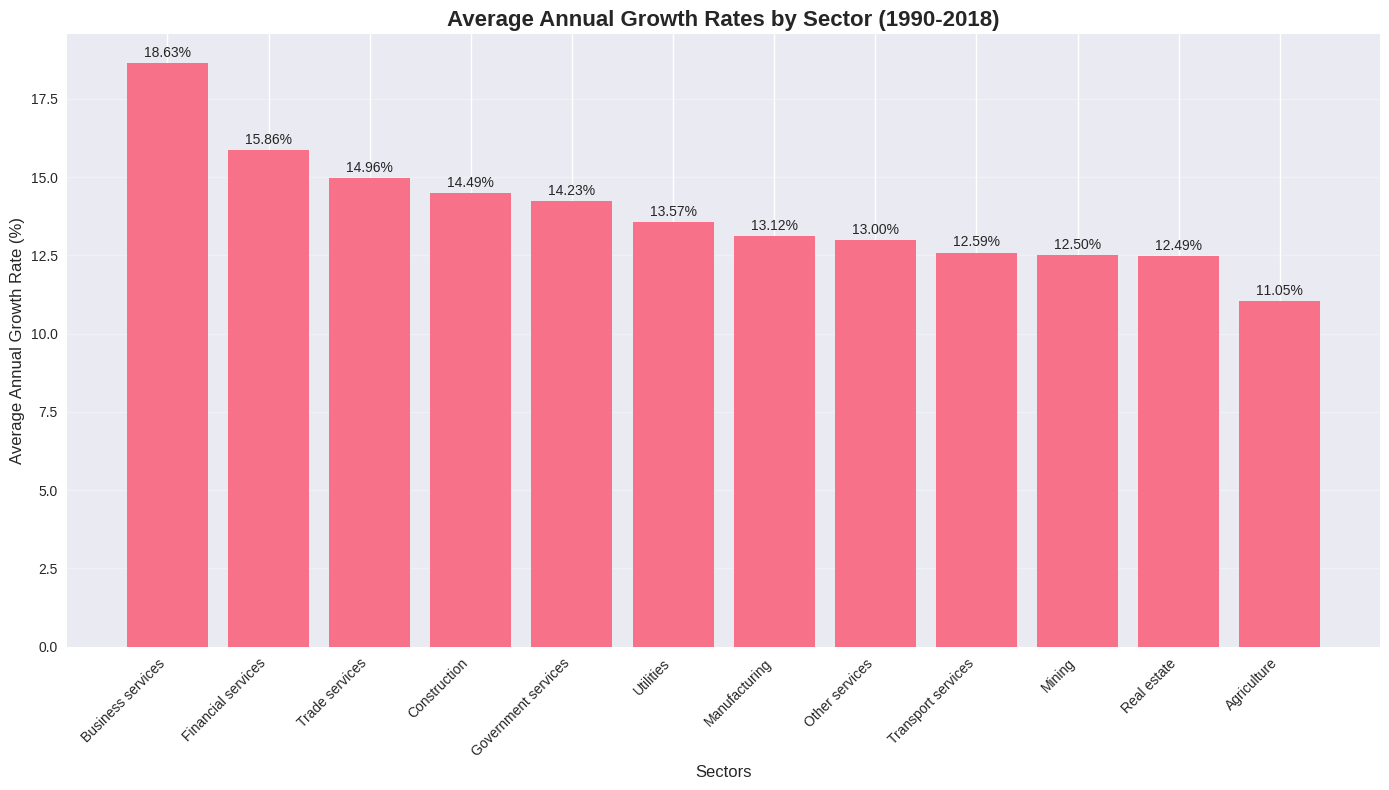

Top 5 fastest growing sectors:
Business services      18.630562
Financial services     15.861623
Trade services         14.961481
Construction           14.489837
Government services    14.227540
dtype: float64


In [ ]:
# Cell 11: Future growth prediction visualization
# Calculate average growth rates for each sector
growth_rates = {}
for sector in sector_columns:
    sector_growth = growth_data[f'{sector}_growth'].mean()
    growth_rates[sector] = sector_growth

# Sort sectors by growth rate
sorted_growth = pd.Series(growth_rates).sort_values(ascending=False)

plt.figure(figsize=(14, 8))
bars = plt.bar(range(len(sorted_growth)), sorted_growth.values)
plt.title('Average Annual Growth Rates by Sector (1990-2018)', fontsize=16, fontweight='bold')
plt.xlabel('Sectors', fontsize=12)
plt.ylabel('Average Annual Growth Rate (%)', fontsize=12)
plt.xticks(range(len(sorted_growth)), sorted_growth.index, rotation=45, ha='right')
plt.grid(True, alpha=0.3, axis='y')

# Add value labels
for i, bar in enumerate(bars):
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height + 0.1,
             f'{height:.2f}%', ha='center', va='bottom')

plt.tight_layout()
plt.show()

print("Top 5 fastest growing sectors:")
print(sorted_growth.head(5))

In [13]:
# Cell 6: Machine Learning Model for Sector Growth Forecasting
def forecast_sector_growth(df, sectors, years_to_forecast=10):
    """
    Forecast future growth for each sector using Linear Regression
    """
    from sklearn.linear_model import LinearRegression
    from sklearn.metrics import r2_score
    import warnings
    warnings.filterwarnings('ignore')

    forecasts = {}
    models = {}
    r2_scores = {}

    # Prepare data
    years = df['year'].values.reshape(-1, 1)

    for sector in sectors:
        if sector in ['country', 'cnt', 'var', 'year', 'Total', 'War flag']:
            continue

        # Get sector data
        sector_data = df[sector].values

        # Create and train model
        model = LinearRegression()
        model.fit(years, sector_data)

        # Make predictions for historical data
        historical_predictions = model.predict(years)

        # Forecast future years
        future_years = np.array(range(df['year'].max() + 1, df['year'].max() + years_to_forecast + 1)).reshape(-1, 1)
        future_predictions = model.predict(future_years)

        # Calculate R² score
        r2 = r2_score(sector_data, historical_predictions)

        # Store results
        forecasts[sector] = {
            'historical_years': years.flatten(),
            'historical_values': sector_data,
            'historical_predictions': historical_predictions,
            'future_years': future_years.flatten(),
            'future_predictions': future_predictions
        }
        models[sector] = model
        r2_scores[sector] = r2

    return forecasts, models, r2_scores

# Define sectors for forecasting
sectors_for_forecast = ['Agriculture', 'Mining', 'Manufacturing', 'Utilities',
                       'Construction', 'Trade services', 'Transport services',
                       'Business services', 'Financial services', 'Real estate',
                       'Government services', 'Other services']

# Generate forecasts
forecasts, models, r2_scores = forecast_sector_growth(df, sectors_for_forecast, years_to_forecast=10)

# Display model performance
print("Model Performance (R² Scores):")
for sector, r2 in r2_scores.items():
    print(f"{sector}: {r2:.4f}")

Model Performance (R² Scores):
Agriculture: 0.7622
Mining: 0.8525
Manufacturing: 0.8440
Utilities: 0.7746
Construction: 0.8566
Trade services: 0.8015
Transport services: 0.8428
Business services: 0.7833
Financial services: 0.8494
Real estate: 0.7881
Government services: 0.7848
Other services: 0.7514


In [14]:
# Cell 8: Improved Realistic Growth Forecasting
def improved_forecast_sector_growth(df, sectors, years_to_forecast=10):
    """
    Improved forecasting using multiple methods with realistic growth constraints
    """
    from sklearn.ensemble import RandomForestRegressor
    from sklearn.preprocessing import StandardScaler
    from sklearn.metrics import r2_score, mean_squared_error
    import warnings
    warnings.filterwarnings('ignore')

    forecasts = {}
    models = {}
    r2_scores = {}

    # Prepare data
    years = df['year'].values.reshape(-1, 1)

    for sector in sectors:
        if sector in ['country', 'cnt', 'var', 'year', 'Total', 'War flag']:
            continue

        # Get sector data
        sector_data = df[sector].values

        # Calculate historical growth rates for realistic constraints
        historical_growth_rates = np.diff(sector_data) / sector_data[:-1]
        avg_growth_rate = np.mean(historical_growth_rates)
        growth_std = np.std(historical_growth_rates)

        # Method 1: Random Forest with feature engineering
        X = years.copy()
        y = sector_data

        # Add polynomial features for non-linear trends
        X_poly = np.column_stack([years.flatten(),
                                 years.flatten()**2,
                                 np.log(years.flatten() - years.min() + 1)])

        # Use Random Forest for better pattern recognition
        rf_model = RandomForestRegressor(n_estimators=100, random_state=42, max_depth=5)
        rf_model.fit(X_poly, y)

        # Historical predictions
        historical_predictions = rf_model.predict(X_poly)

        # Future predictions with realistic growth constraints
        future_years = np.array(range(df['year'].max() + 1, df['year'].max() + years_to_forecast + 1))

        # Prepare future features
        X_future = np.column_stack([future_years,
                                   future_years**2,
                                   np.log(future_years - years.min() + 1)])

        # Get base predictions
        future_predictions = rf_model.predict(X_future)

        # Apply realistic growth constraints based on historical patterns
        future_predictions = apply_growth_constraints(
            sector_data, future_predictions, historical_growth_rates
        )

        # Smooth the predictions to avoid unrealistic jumps
        future_predictions = smooth_predictions(future_predictions, smoothing_factor=0.3)

        # Ensure predictions don't go negative
        future_predictions = np.maximum(future_predictions, 0)

        # Calculate R² score
        r2 = r2_score(sector_data, historical_predictions)

        # Store results
        forecasts[sector] = {
            'historical_years': years.flatten(),
            'historical_values': sector_data,
            'historical_predictions': historical_predictions,
            'future_years': future_years,
            'future_predictions': future_predictions,
            'avg_growth_rate': avg_growth_rate
        }
        models[sector] = rf_model
        r2_scores[sector] = r2

    return forecasts, models, r2_scores

def apply_growth_constraints(historical_data, future_predictions, historical_growth_rates):
    """
    Apply realistic growth constraints based on historical patterns
    """
    avg_growth = np.mean(historical_growth_rates)
    growth_std = np.std(historical_growth_rates)

    # Cap growth rates to reasonable levels (within 2 std of historical)
    max_growth_rate = avg_growth + 2 * growth_std
    min_growth_rate = avg_growth - 2 * growth_std

    adjusted_predictions = future_predictions.copy()
    last_historical = historical_data[-1]

    for i in range(len(future_predictions)):
        if i == 0:
            prev_value = last_historical
        else:
            prev_value = adjusted_predictions[i-1]

        implied_growth = (future_predictions[i] - prev_value) / prev_value

        # Constrain growth to realistic bounds
        if implied_growth > max_growth_rate:
            adjusted_predictions[i] = prev_value * (1 + max_growth_rate)
        elif implied_growth < min_growth_rate:
            adjusted_predictions[i] = prev_value * (1 + min_growth_rate)

    return adjusted_predictions

def smooth_predictions(predictions, smoothing_factor=0.3):
    """
    Smooth predictions to avoid unrealistic volatility
    """
    smoothed = predictions.copy()
    for i in range(1, len(predictions)):
        smoothed[i] = (smoothing_factor * predictions[i] +
                      (1 - smoothing_factor) * smoothed[i-1])
    return smoothed

# Generate improved forecasts
improved_forecasts, improved_models, improved_r2_scores = improved_forecast_sector_growth(
    df, sectors_for_forecast, years_to_forecast=10
)

# Display improved model performance
print("Improved Model Performance (R² Scores):")
for sector, r2 in improved_r2_scores.items():
    print(f"{sector}: {r2:.4f}")

Improved Model Performance (R² Scores):
Agriculture: 0.9727
Mining: 0.9845
Manufacturing: 0.9967
Utilities: 0.9932
Construction: 0.9953
Trade services: 0.9963
Transport services: 0.9966
Business services: 0.9984
Financial services: 0.9969
Real estate: 0.9895
Government services: 0.9945
Other services: 0.9894


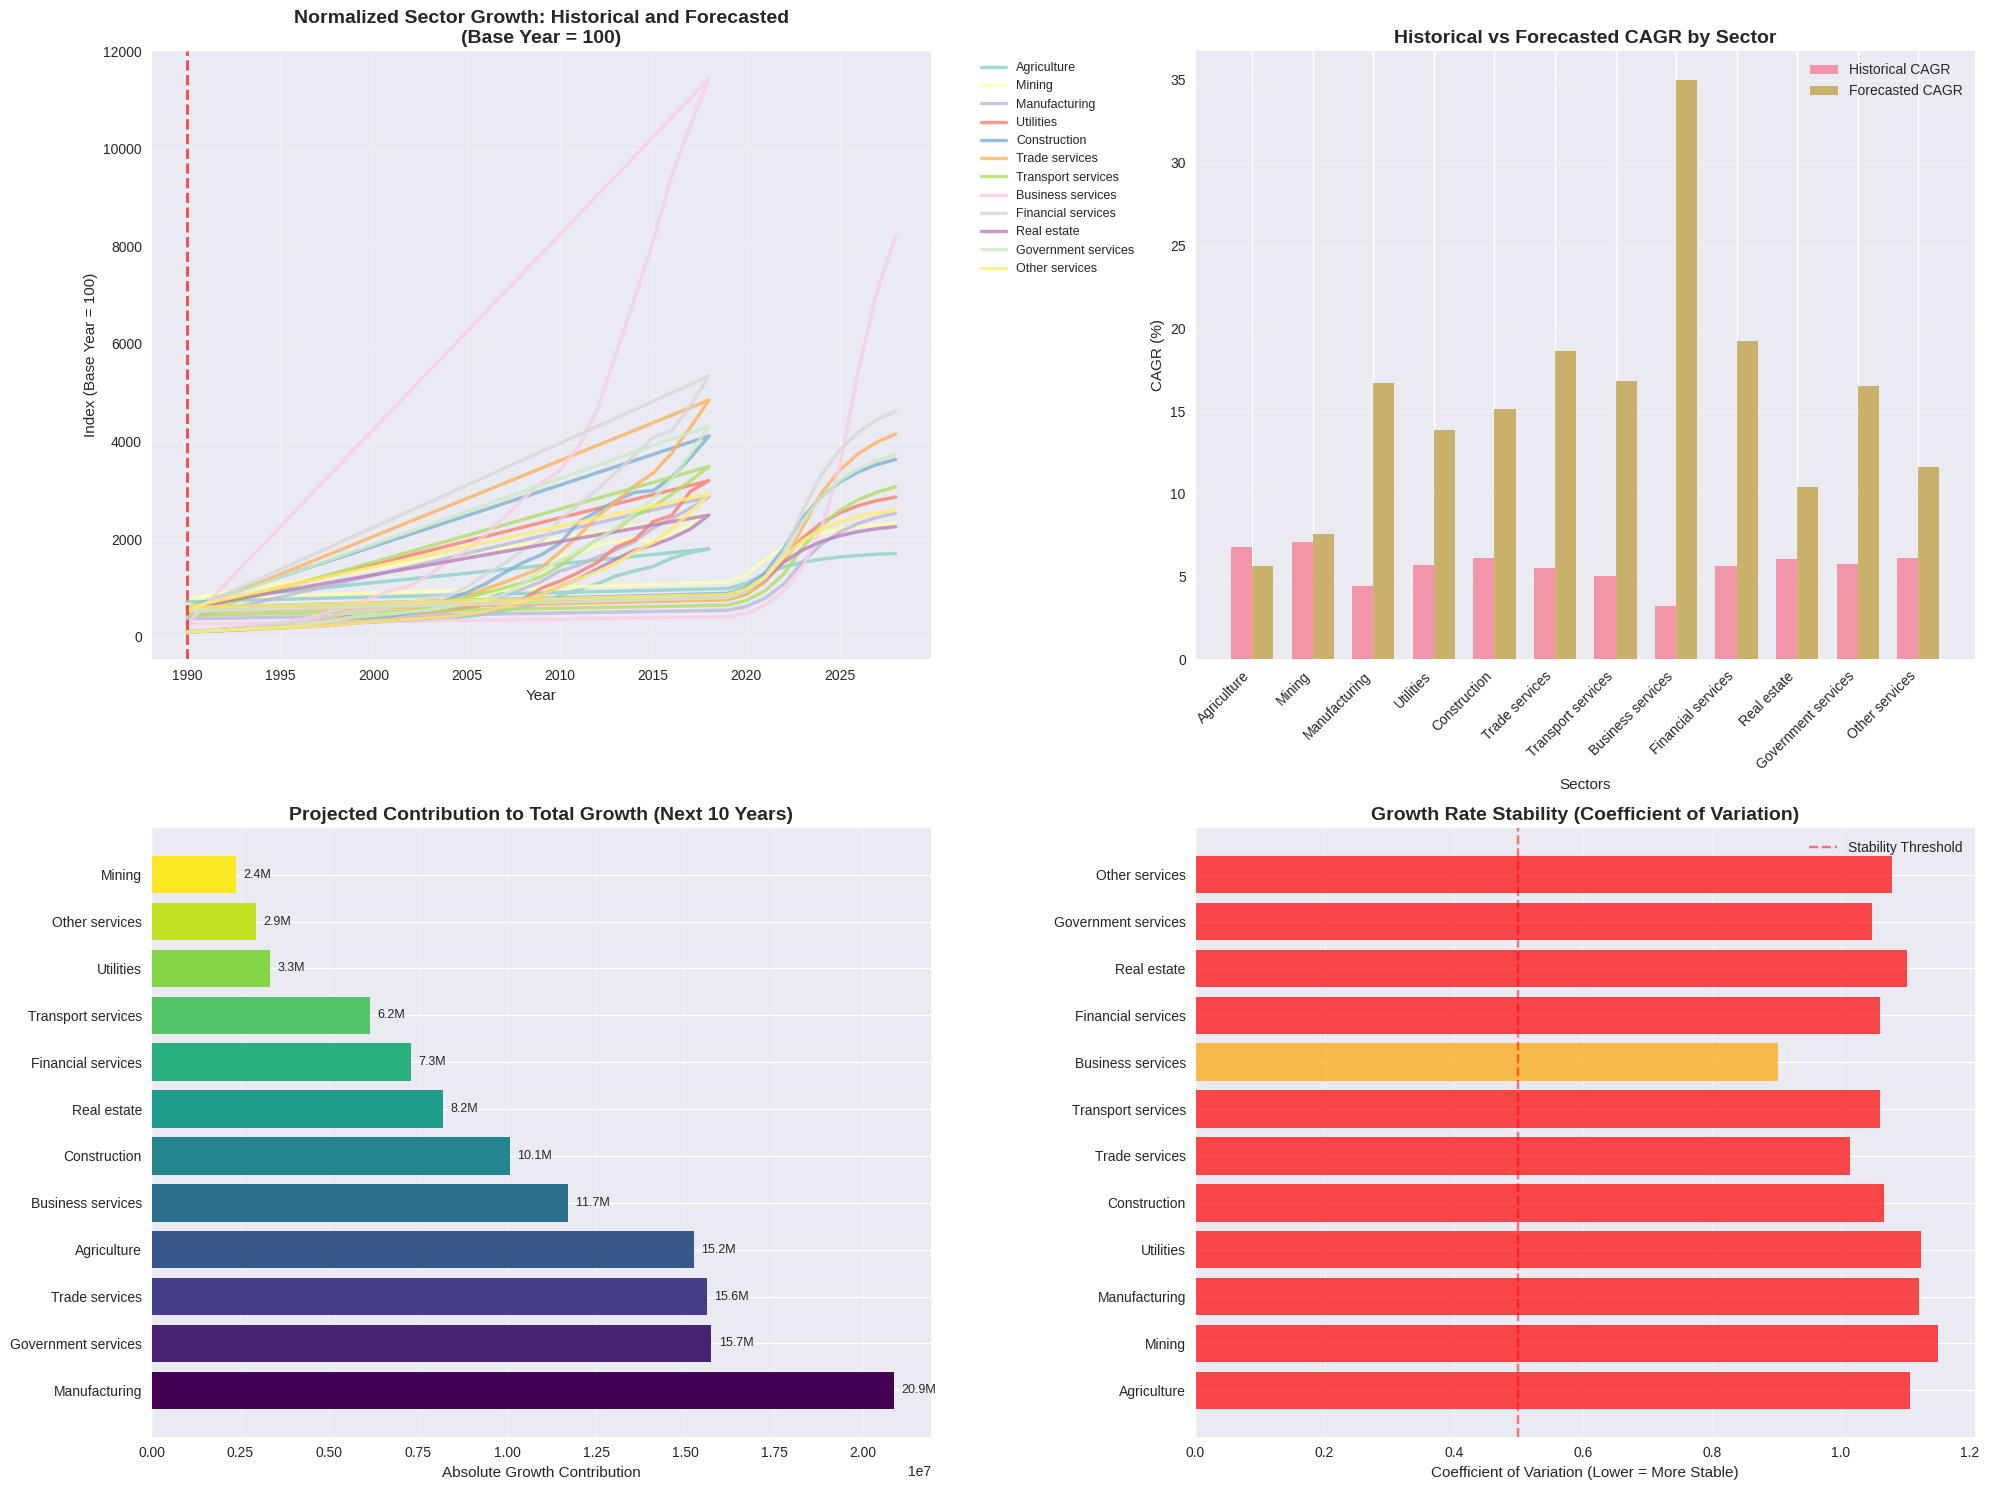

In [15]:
# Cell 9: Enhanced Comparative Growth Analysis
def plot_enhanced_comparative_growth(forecasts):
    """
    Enhanced comparative analysis with realistic growth patterns
    """
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(20, 15))

    # Colors for better visualization
    colors = plt.cm.Set3(np.linspace(0, 1, len(forecasts)))

    # Plot 1: Historical and Forecasted Values (Normalized)
    ax1.set_title('Normalized Sector Growth: Historical and Forecasted\n(Base Year = 100)',
                 fontsize=14, fontweight='bold')

    for idx, (sector, forecast_data) in enumerate(forecasts.items()):
        # Normalize to base year for better comparison
        base_value = forecast_data['historical_values'][0]
        normalized_historical = forecast_data['historical_values'] / base_value * 100
        normalized_forecast = forecast_data['future_predictions'] / base_value * 100

        all_years = np.concatenate([forecast_data['historical_years'],
                                   forecast_data['future_years']])
        all_values = np.concatenate([normalized_historical, normalized_forecast])

        ax1.plot(all_years, all_values, linewidth=2.5, label=sector, color=colors[idx], alpha=0.8)

    ax1.set_xlabel('Year')
    ax1.set_ylabel('Index (Base Year = 100)')
    ax1.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=9)
    ax1.grid(True, alpha=0.3)

    # Add vertical line to separate historical and forecast
    last_historical_year = list(forecasts.values())[0]['historical_years'][-1]
    ax1.axvline(x=last_historical_year, color='red', linestyle='--', alpha=0.7,
                label='Forecast Start', linewidth=2)

    # Plot 2: Growth Rates Comparison
    ax2.set_title('Historical vs Forecasted CAGR by Sector', fontsize=14, fontweight='bold')

    sectors_list = []
    historical_cagrs = []
    forecast_cagrs = []

    for sector, forecast_data in forecasts.items():
        historical_values = forecast_data['historical_values']
        future_predictions = forecast_data['future_predictions']

        # Calculate CAGR
        historical_cagr = ((historical_values[-1] / historical_values[0]) **
                          (1/len(historical_values)) - 1) * 100
        forecast_cagr = ((future_predictions[-1] / future_predictions[0]) **
                        (1/len(future_predictions)) - 1) * 100

        sectors_list.append(sector)
        historical_cagrs.append(historical_cagr)
        forecast_cagrs.append(forecast_cagr)

    x_pos = np.arange(len(sectors_list))
    width = 0.35

    ax2.bar(x_pos - width/2, historical_cagrs, width, label='Historical CAGR', alpha=0.7)
    ax2.bar(x_pos + width/2, forecast_cagrs, width, label='Forecasted CAGR', alpha=0.7)

    ax2.set_xlabel('Sectors')
    ax2.set_ylabel('CAGR (%)')
    ax2.set_xticks(x_pos)
    ax2.set_xticklabels(sectors_list, rotation=45, ha='right')
    ax2.legend()
    ax2.grid(True, alpha=0.3, axis='y')

    # Plot 3: Sector Contribution to Total Growth
    ax3.set_title('Projected Contribution to Total Growth (Next 10 Years)',
                 fontsize=14, fontweight='bold')

    total_growth_contributions = []
    for sector, forecast_data in forecasts.items():
        growth_contribution = (forecast_data['future_predictions'][-1] -
                             forecast_data['historical_values'][-1])
        total_growth_contributions.append(growth_contribution)

    # Sort by contribution
    sorted_indices = np.argsort(total_growth_contributions)[::-1]
    sorted_sectors = [sectors_list[i] for i in sorted_indices]
    sorted_contributions = [total_growth_contributions[i] for i in sorted_indices]

    colors_contrib = plt.cm.viridis(np.linspace(0, 1, len(sorted_contributions)))
    bars = ax3.barh(sorted_sectors, sorted_contributions, color=colors_contrib)

    ax3.set_xlabel('Absolute Growth Contribution')
    ax3.grid(True, alpha=0.3, axis='x')

    # Add value labels on bars
    for bar, value in zip(bars, sorted_contributions):
        width = bar.get_width()
        ax3.text(width + max(sorted_contributions)*0.01, bar.get_y() + bar.get_height()/2,
                f'{width/1e6:.1f}M', ha='left', va='center', fontsize=9)

    # Plot 4: Growth Stability Analysis
    ax4.set_title('Growth Rate Stability (Coefficient of Variation)',
                 fontsize=14, fontweight='bold')

    stability_scores = []
    for sector, forecast_data in forecasts.items():
        # Calculate coefficient of variation for growth rates
        historical_growth = np.diff(forecast_data['historical_values']) / forecast_data['historical_values'][:-1]
        forecast_growth = np.diff(forecast_data['future_predictions']) / forecast_data['future_predictions'][:-1]

        all_growth = np.concatenate([historical_growth, forecast_growth])
        cv = np.std(all_growth) / np.mean(np.abs(all_growth))  # Coefficient of variation

        stability_scores.append(cv)

    # Lower CV means more stable growth
    stability_colors = ['green' if score < 0.5 else 'orange' if score < 1 else 'red'
                       for score in stability_scores]

    ax4.barh(sectors_list, stability_scores, color=stability_colors, alpha=0.7)
    ax4.set_xlabel('Coefficient of Variation (Lower = More Stable)')
    ax4.axvline(x=0.5, color='red', linestyle='--', alpha=0.5, label='Stability Threshold')
    ax4.legend()
    ax4.grid(True, alpha=0.3, axis='x')

    plt.tight_layout()
    plt.show()

    return sectors_list, historical_cagrs, forecast_cagrs

# Plot enhanced comparative analysis
sectors_list, historical_cagrs, forecast_cagrs = plot_enhanced_comparative_growth(improved_forecasts)

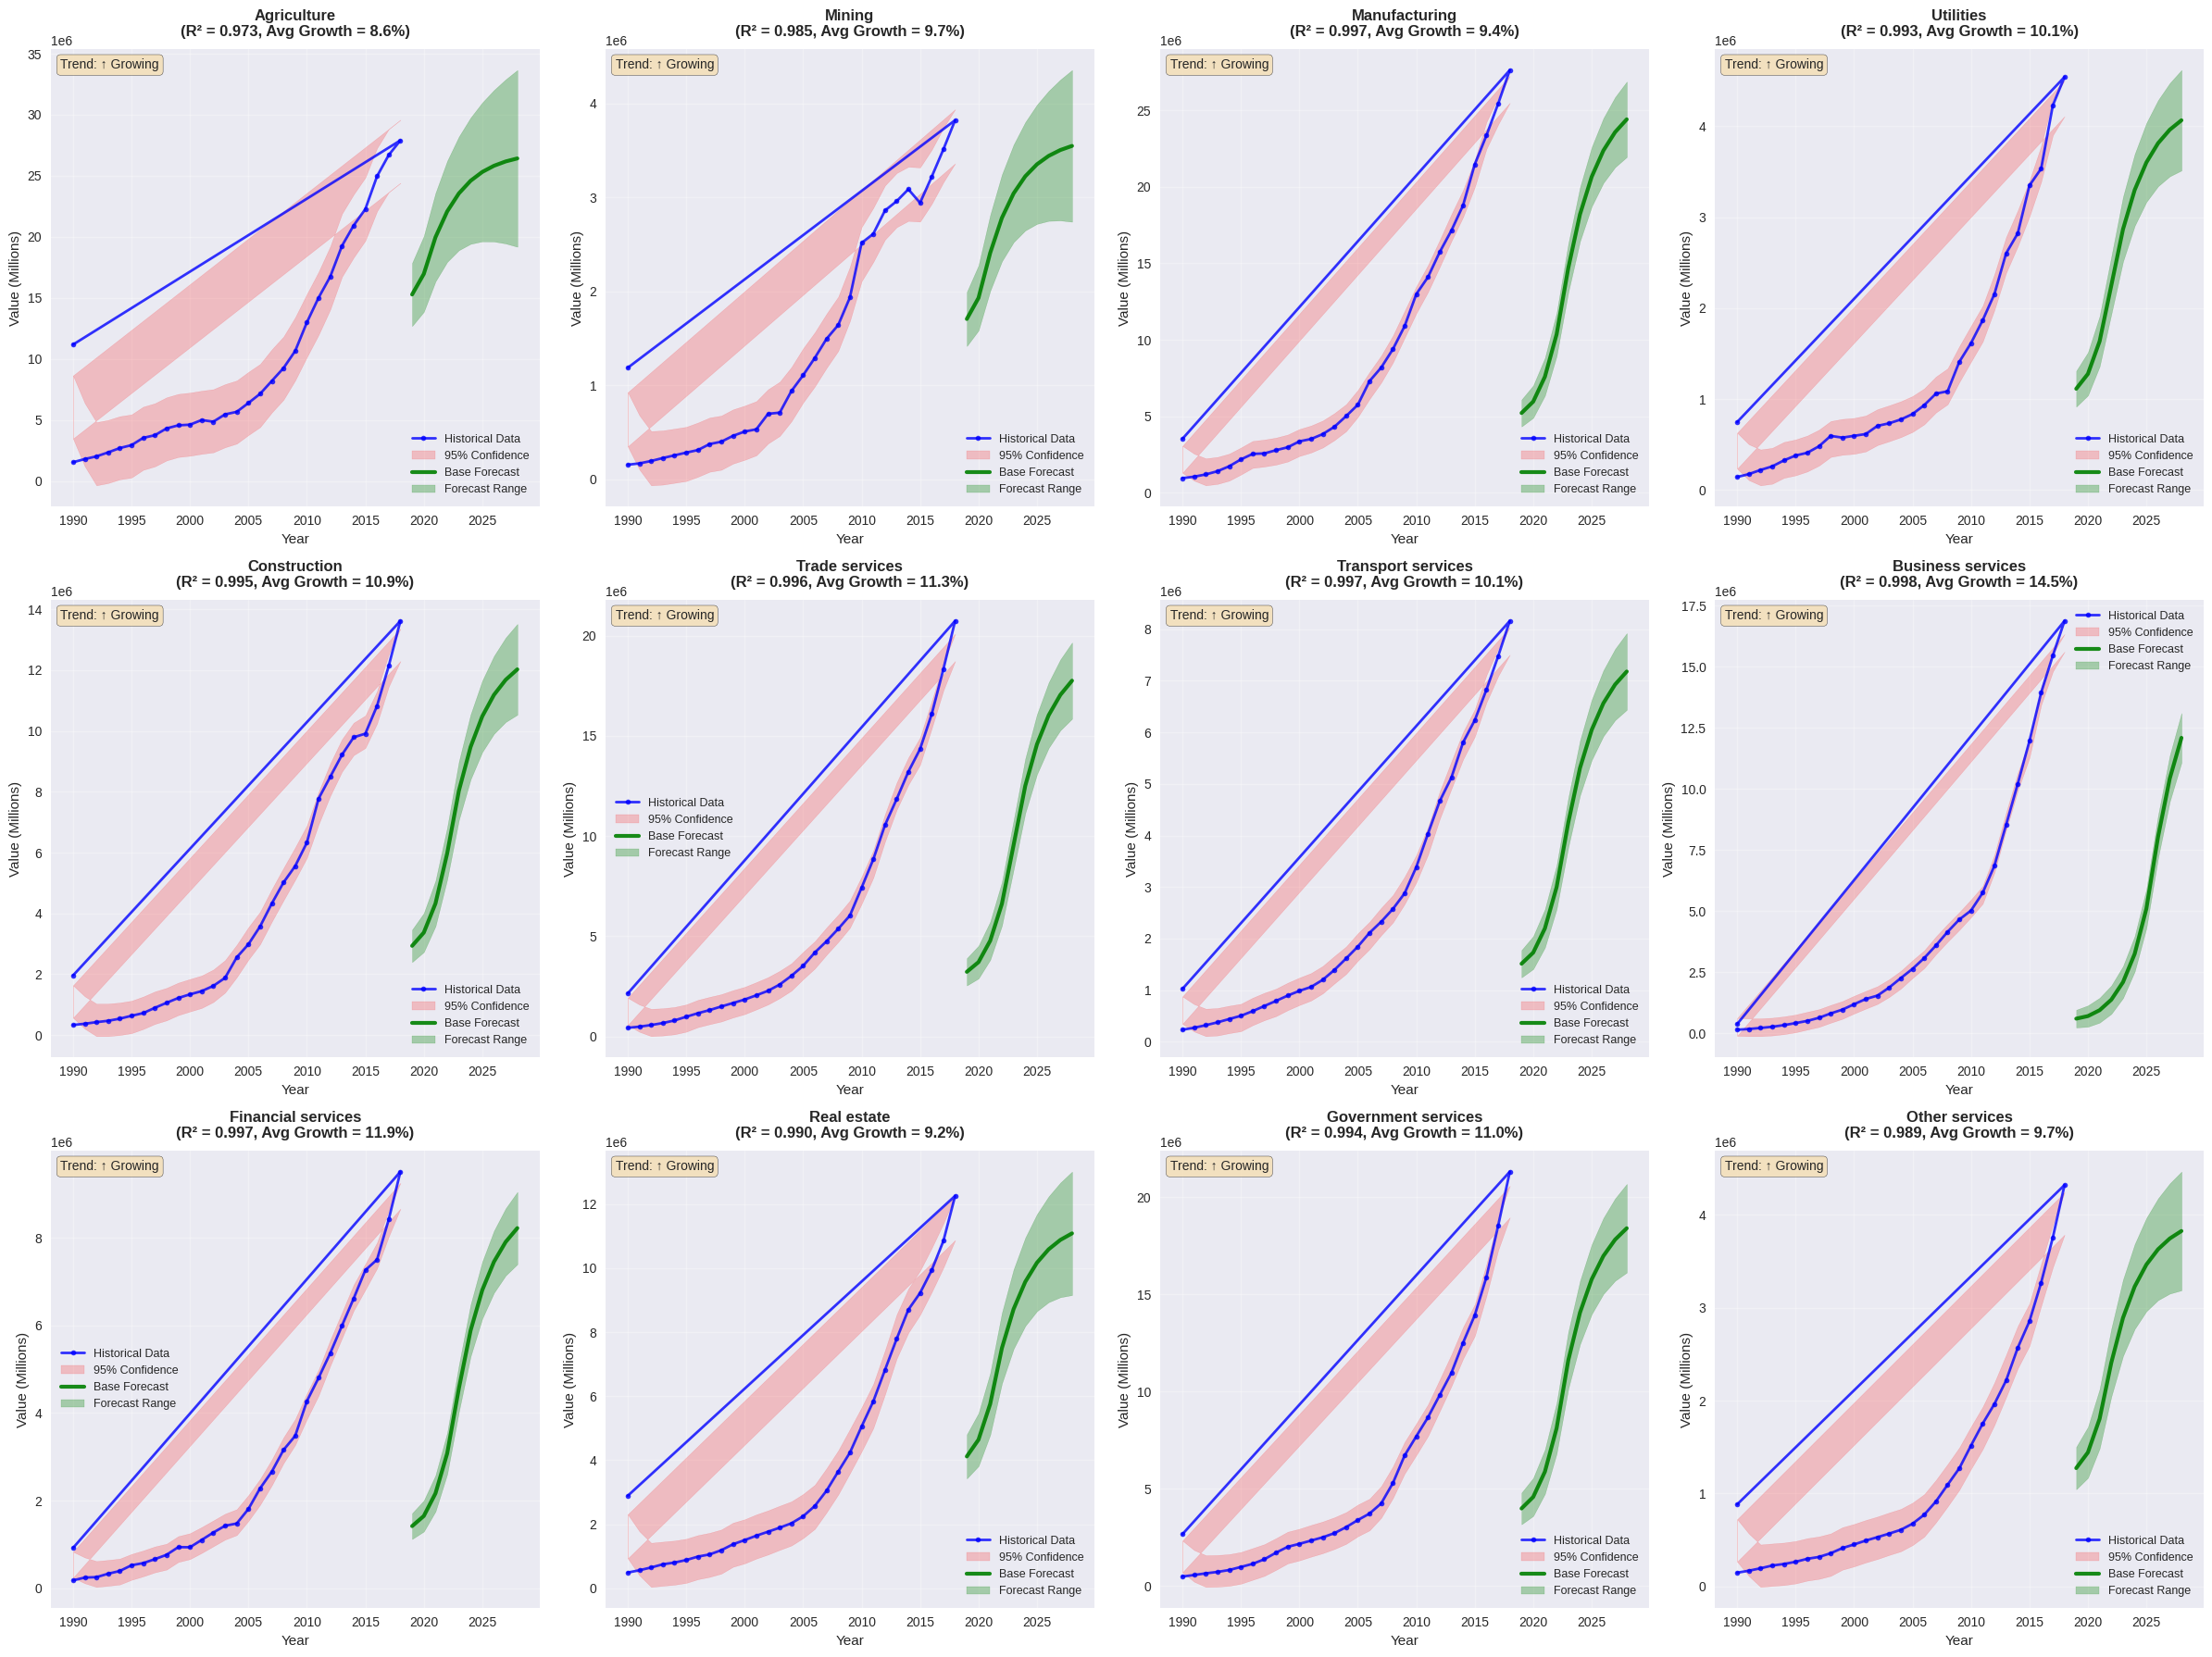

In [16]:
# Cell 10: Realistic Individual Sector Forecast Plots
def plot_realistic_sector_forecasts(forecasts, r2_scores):
    """
    Create realistic individual growth plots for each sector with confidence intervals
    """
    n_sectors = len(forecasts)
    cols = 4
    rows = (n_sectors + cols - 1) // cols

    fig, axes = plt.subplots(rows, cols, figsize=(24, 6*rows))
    axes = axes.flatten()

    for idx, (sector, forecast_data) in enumerate(forecasts.items()):
        ax = axes[idx]

        # Historical data with confidence band
        historical_years = forecast_data['historical_years']
        historical_values = forecast_data['historical_values']

        # Calculate confidence interval for historical data
        historical_std = np.std(historical_values - forecast_data['historical_predictions'])
        confidence_band = 1.96 * historical_std

        # Plot historical data with confidence
        ax.plot(historical_years, historical_values, 'bo-',
                linewidth=2, markersize=4, label='Historical Data', alpha=0.8)
        ax.fill_between(historical_years,
                       forecast_data['historical_predictions'] - confidence_band,
                       forecast_data['historical_predictions'] + confidence_band,
                       alpha=0.2, color='red', label='95% Confidence')

        # Future forecast with uncertainty
        future_years = forecast_data['future_years']
        future_predictions = forecast_data['future_predictions']

        # Increase uncertainty for future predictions
        future_uncertainty = confidence_band * (1 + np.arange(len(future_years)) * 0.2)

        ax.plot(future_years, future_predictions, 'g-',
                linewidth=3, label='Base Forecast', alpha=0.9)
        ax.fill_between(future_years,
                       future_predictions - future_uncertainty,
                       future_predictions + future_uncertainty,
                       alpha=0.3, color='green', label='Forecast Range')

        # Formatting
        ax.set_title(f'{sector}\n(R² = {r2_scores[sector]:.3f}, Avg Growth = {forecast_data["avg_growth_rate"]*100:.1f}%)',
                    fontsize=12, fontweight='bold', pad=10)
        ax.set_xlabel('Year')
        ax.set_ylabel('Value')
        ax.legend(fontsize=9)
        ax.grid(True, alpha=0.3)

        # Add trend analysis annotation
        trend_direction = "↑ Growing" if forecast_data['avg_growth_rate'] > 0 else "↓ Declining"
        ax.text(0.02, 0.98, f'Trend: {trend_direction}',
               transform=ax.transAxes, verticalalignment='top',
               bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8),
               fontsize=10)

        # Format y-axis
        y_max = max(np.max(historical_values), np.max(future_predictions + future_uncertainty))
        if y_max > 1e6:
            ax.ticklabel_format(axis='y', style='sci', scilimits=(6,6))
            ax.set_ylabel('Value (Millions)')

    # Hide empty subplots
    for idx in range(len(forecasts), len(axes)):
        axes[idx].set_visible(False)

    plt.tight_layout()
    plt.show()

# Plot realistic individual forecasts
plot_realistic_sector_forecasts(improved_forecasts, improved_r2_scores)

GROWTH SCENARIO ANALYSIS


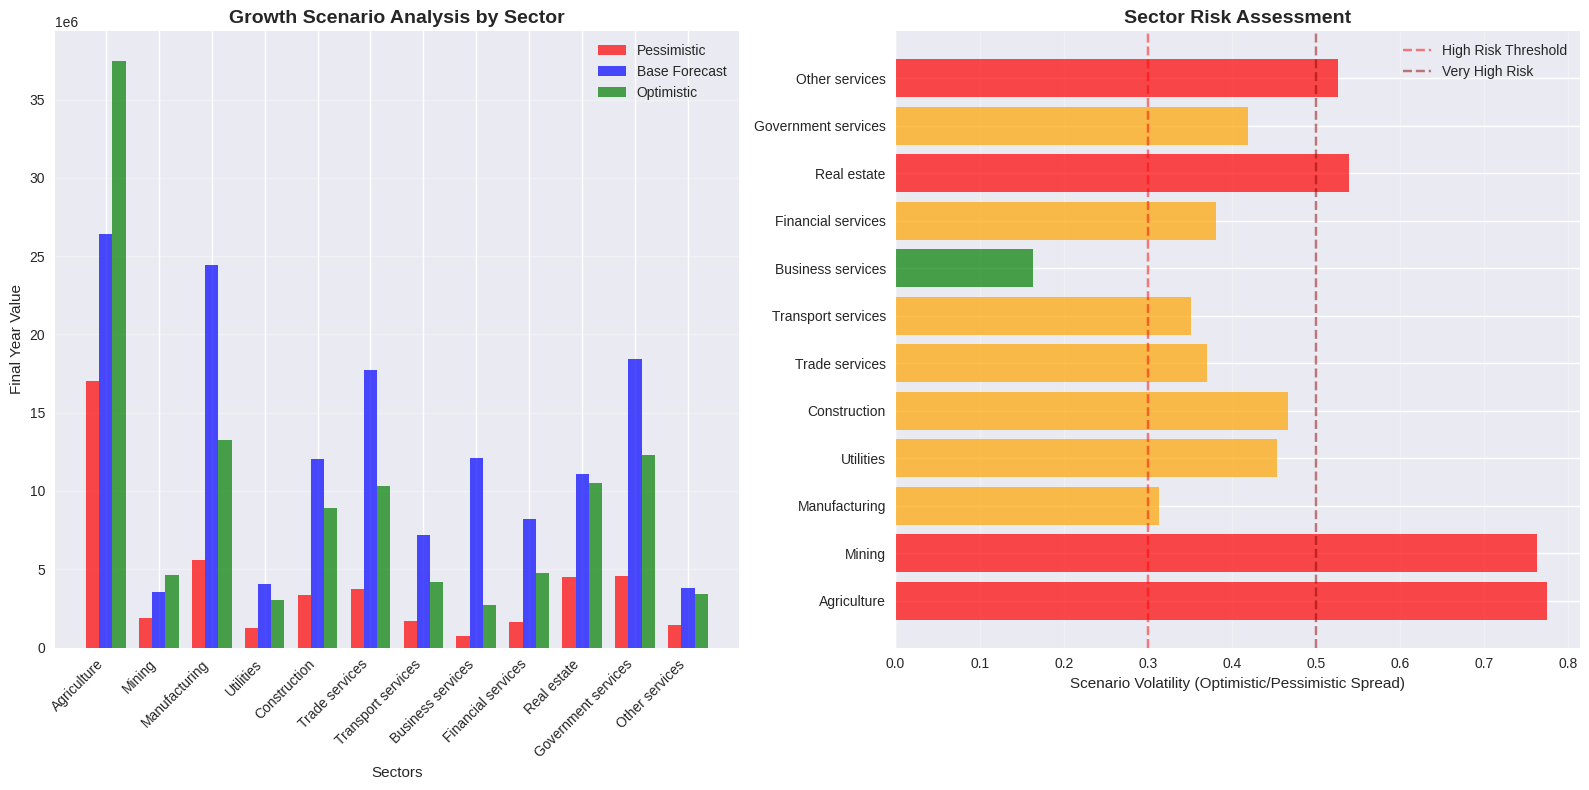

In [17]:
# Cell 11: Growth Scenario Analysis
def analyze_growth_scenarios(forecasts):
    """
    Analyze different growth scenarios for risk assessment
    """
    print("="*70)
    print("GROWTH SCENARIO ANALYSIS")
    print("="*70)

    scenarios = {}

    for sector, forecast_data in forecasts.items():
        base_forecast = forecast_data['future_predictions'][-1]
        historical_avg_growth = forecast_data['avg_growth_rate']

        # Calculate different scenarios
        optimistic_growth = historical_avg_growth * 1.5  # 50% better than historical
        pessimistic_growth = historical_avg_growth * 0.5  # 50% worse than historical

        last_historical = forecast_data['historical_values'][-1]
        years_forecast = len(forecast_data['future_years'])

        optimistic_value = last_historical * (1 + optimistic_growth) ** years_forecast
        pessimistic_value = last_historical * (1 + pessimistic_growth) ** years_forecast

        scenarios[sector] = {
            'base': base_forecast,
            'optimistic': optimistic_value,
            'pessimistic': pessimistic_value,
            'volatility': (optimistic_value - pessimistic_value) / base_forecast
        }

    # Plot scenario analysis
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))

    # Scenario values
    sectors = list(scenarios.keys())
    base_values = [scenarios[s]['base'] for s in sectors]
    optimistic_values = [scenarios[s]['optimistic'] for s in sectors]
    pessimistic_values = [scenarios[s]['pessimistic'] for s in sectors]

    x_pos = np.arange(len(sectors))
    width = 0.25

    ax1.bar(x_pos - width, pessimistic_values, width, label='Pessimistic', alpha=0.7, color='red')
    ax1.bar(x_pos, base_values, width, label='Base Forecast', alpha=0.7, color='blue')
    ax1.bar(x_pos + width, optimistic_values, width, label='Optimistic', alpha=0.7, color='green')

    ax1.set_xlabel('Sectors')
    ax1.set_ylabel('Final Year Value')
    ax1.set_title('Growth Scenario Analysis by Sector', fontsize=14, fontweight='bold')
    ax1.set_xticks(x_pos)
    ax1.set_xticklabels(sectors, rotation=45, ha='right')
    ax1.legend()
    ax1.grid(True, alpha=0.3, axis='y')
    ax1.ticklabel_format(axis='y', style='sci', scilimits=(6,6))

    # Volatility analysis
    volatilities = [scenarios[s]['volatility'] for s in sectors]
    colors_vol = ['red' if vol > 0.5 else 'orange' if vol > 0.3 else 'green' for vol in volatilities]

    ax2.barh(sectors, volatilities, color=colors_vol, alpha=0.7)
    ax2.set_xlabel('Scenario Volatility (Optimistic/Pessimistic Spread)')
    ax2.set_title('Sector Risk Assessment', fontsize=14, fontweight='bold')
    ax2.axvline(x=0.3, color='red', linestyle='--', alpha=0.5, label='High Risk Threshold')
    ax2.axvline(x=0.5, color='darkred', linestyle='--', alpha=0.5, label='Very High Risk')
    ax2.legend()
    ax2.grid(True, alpha=0.3, axis='x')

    plt.tight_layout()
    plt.show()

    return scenarios

# Run scenario analysis
growth_scenarios = analyze_growth_scenarios(improved_forecasts)